In [17]:

import os
import glob
import json
import h5py
import copy
import cv2
import imutils
import itertools
import time
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns
import cPickle as pkl

import matplotlib.gridspec as gridspec

from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator

import matplotlib_venn as mpvenn

import multiprocessing as mp


In [18]:

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import test_responsivity as resp
from pipeline.python.classifications import responsivity_stats as rstats
from pipeline.python.utils import label_figure, natural_keys, convert_range
from pipeline.python.retinotopy import convert_coords as coor
from pipeline.python.retinotopy import fit_2d_rfs as fitrf

In [19]:
%matplotlib notebook

In [20]:
def get_session_object(animalid, session, fov, traceid='traces001', trace_type='corrected',
                       create_new=True, rootdir='/n/coxfs01/2p-data'):
    
    # Create output dir for session summary 
    summarydir = os.path.join(rootdir, animalid, session, fov, 'summaries')
    session_outfile = os.path.join(summarydir, 'sessiondata.pkl')
    
    # Load existing sessiondata file
    if os.path.exists(session_outfile) and create_new is False:
        print("... loading session object")
        with open(session_outfile, 'rb') as f:
            S = pkl.load(f)
    else:
        print("... creating new session object")
        S = util.Session(animalid, session, fov, rootdir=rootdir)
    
        # Save session data object
        if not os.path.exists(summarydir):
            os.makedirs(summarydir)
            
        with open(session_outfile, 'wb') as f:
            pkl.dump(S, f, protocol=pkl.HIGHEST_PROTOCOL)
            print("... new session object to: %s" % session_outfile)
            
    print("... got session object w/ experiments:", S.experiments)
    
    try:
        print("Found %i experiments in current session:" % len(S.experiment_list), S.experiment_list)
        assert 'rfs' in S.experiment_list or 'rfs10' in S.experiment_list, "ERROR:  No receptive field mapping found for current dataset: [%s|%s|%s]" % (S.animalid, S.session, S.fov)
    except Exception as e:
        print e
        return None
    return S

# Set out dir

In [129]:
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
outdir = os.path.join(aggregate_dir, 'receptive-fields', 'visual-field-coverage')
print outdir

if not os.path.exists(os.path.join(outdir, 'heatmaps')):
    os.makedirs(os.path.join(outdir, 'heatmaps'))
if not os.path.exists(os.path.join(outdir, 'summaries')):
    os.makedirs(os.path.join(outdir, 'summaries'))

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/visual-field-coverage


In [22]:
os.path.exists(outdir)

True

# Get aggregate data

In [23]:
from pipeline.python.classifications import get_dataset_stats as gd
import cPickle as pkl

options = ['-t', 'traces001']
optsE = gd.extract_options(options)

rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type
traceid = optsE.traceid
response_type = 'dff'
print aggregate_dir

/n/coxfs01/julianarhee/aggregate-visual-areas


In [24]:
sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
if os.path.exists(sdata_fpath):
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
else:
    sdata = gd.aggregate_session_info(traceid=optsE.traceid, trace_type=optsE.trace_type, 
                                       state=optsE.state, fov_type=optsE.fov_type, 
                                       visual_areas=optsE.visual_areas,
                                       blacklist=optsE.blacklist, 
                                       rootdir=optsE.rootdir)
    with open(sdata_fpath, 'wb') as f:
        pkl.dump(sdata, f, protocol=pkl.HIGHEST_PROTOCOL)
#dsets = sdata[sdata['experiment']==experiment_type]

#### Response params

In [25]:

traceid = 'traces001'

create_new = False
trace_type = 'corrected'
responsive_test = 'nstds'
responsive_thr = 10.
convert_um = True
response_type = 'dff'

#### Stimulus params

In [26]:
# RF conversion info
sigma_scale = 2.35
min_sigma=5
max_sigma=50
dx = dy = 1.0  # grid resolution; this can be adjusted


In [82]:
dset

,animalid,experiment,fov,session,visual_area
116,JC076,blobs,FOV1_zoom2p0x,20190502,Li
117,JC076,rfs,FOV1_zoom2p0x,20190502,Li


Li JC076
... creating new session object
[JC076] 20190502 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... new session object to: /n/coxfs01/2p-data/JC076/20190502/FOV1_zoom2p0x/summaries/sessiondata.pkl
('... got session object w/ experiments:', {})
('Found 2 experiments in current session:', ['blobs', 'rfs'])
Calculating stats
[blobs] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'blobs')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (blobs - traces001 - corrected)
('... Getting experiment data:', ['blobs'])
... ... loading: blobs
... ... got rois
... [JC076|20190502|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... loading data array
/n/coxfs01/2p-data/JC076/20190502/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_bc0893_traces001_05b262_traces001_cdf7b0_traces0

<IPython.core.display.Javascript object>


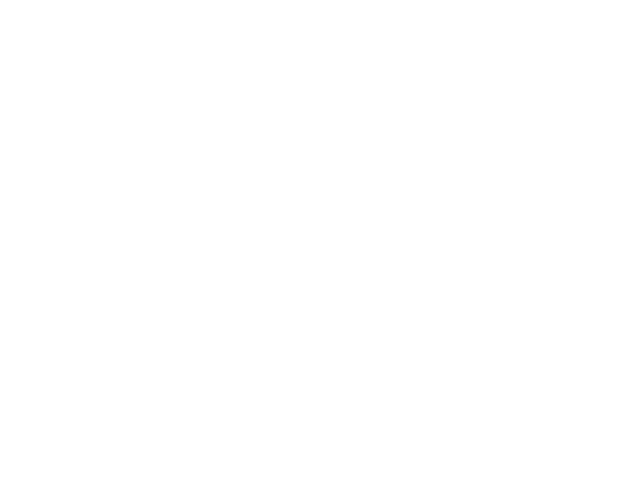

No localized gratings
Blobs - min/max size: (10, 50)
('stimuli presented @:', -5.0, 8.0)


<IPython.core.display.Javascript object>


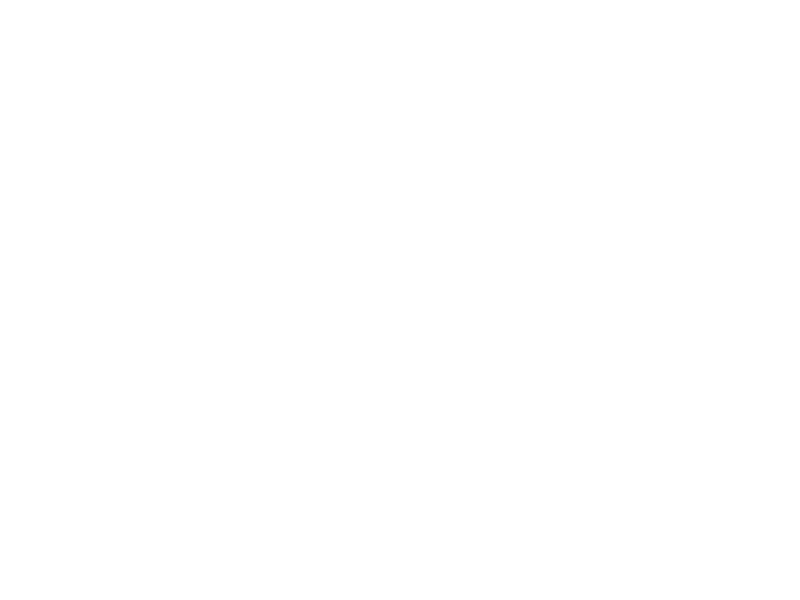

Li JC090
... creating new session object
[JC090] 20190605 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... new session object to: /n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/summaries/sessiondata.pkl
('... got session object w/ experiments:', {})
('Found 4 experiments in current session:', ['rfs10', 'gratings', 'blobs', 'retino'])
Calculating stats
[rfs10] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'rfs10')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (rfs10 - traces001 - corrected)
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... [JC090|20190605|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... loading data array
/n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_42e6c7_traces001_db48cb_

Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1010, in load
    traceid=self.traceid)
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


adding NP offset...
... updating self
... ... loaded traces
... gratings: calculating stats
... [combined_gratings_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
[blobs] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'blobs')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (blobs - traces001 - corrected)
('... Getting experiment data:', ['blobs'])
... ... loading: blobs
... ... got rois
... [JC090|20190605|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... loading data array
/n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_5afb30_traces001_ea6bc7_traces001_9747d8_traces001_70031f_traces001_ba4282_traces001_c2eec5_traces001_5c088e/data_arrays/np_subtracted.npz
adding NP offset...
... adjusting for equ

<IPython.core.display.Javascript object>


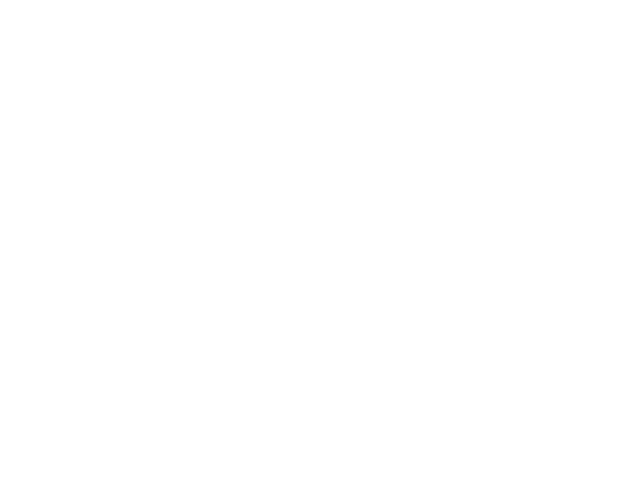

Gratings - apertured size: 40
Blobs - min/max size: (10, 50)
('stimuli presented @:', 15.0, 0.0)


<IPython.core.display.Javascript object>


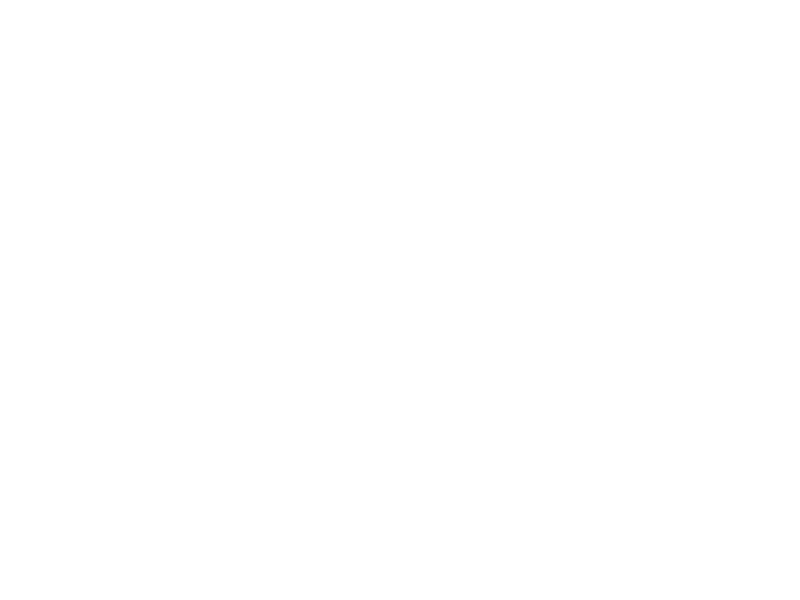

Li JC091
... creating new session object
[JC091] 20190602 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... new session object to: /n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/summaries/sessiondata.pkl
('... got session object w/ experiments:', {})
('Found 5 experiments in current session:', ['rfs', 'rfs10', 'gratings', 'blobs', 'retino'])
Calculating stats
[rfs] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'rfs')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (rfs - traces001 - corrected)
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... [JC091|20190602|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... loading data array
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_0b8258_traces001_1cd00d_traces001_d

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -89.30238500851786
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -344.88550079067375
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -402.23721590909076
STIM TYPE: gratings
**** File 9 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run1
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 8 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -60.90013495276639
Showing initial drift correction (quantile: 0.10)
Min 

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -63.54545454545439
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -336.39674306781353
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -319.98011363636385
STIM TYPE: gratings
**** File 19 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run3
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 1 (has 2911 frames)
... asking for 10 extra frames...
... Last frame to align: 2921 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -72.96903460837882
Showing initial drift correction (quantile: 0.10)
Min

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -83.08500303582275
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -594.0082352096881
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -585.5287298387095
STIM TYPE: gratings
**** File 29 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run4
N tsecs: 2911
There are 270 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 0 (has 2911 frames)
... asking for 10 extra frames...
... Last frame to align: 2921 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -63.8518284993695
Showing initial drift correction (quantile: 0.10)
Min va

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/trial_alignment.py:444: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  currdf['ix'] = [total_ix for _ in range(currdf.shape[0])]
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/trial_alignment.py:448: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  currf0['ix'] = [total_ix for _ in range(currdf.shape[0])]


Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -303.6548113567072
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -283.2939691310976
STIM TYPE: gratings
**** File 36 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run5
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 0 (has 2911 frames)
... asking for 10 extra frames...
... Last frame to align: 2921 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -57.337320574162504
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -252.90519531249998
Showing initial drift correction (quantile: 0.10)
Min

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -61.7147562582345
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -284.8320347920362
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -287.00206972947785
STIM TYPE: gratings
**** File 46 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run5
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 10 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -67.06616643929055
Showing initial drift correction (quantile: 0.10)
Min 

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -81.80541237113403
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -398.75166507277606
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -341.44733796296305
STIM TYPE: gratings
**** File 56 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run6
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 9 (has 2911 frames)
... asking for 10 extra frames...
... Last frame to align: 2921 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -72.46451612903218
Showing initial drift correction (quantile: 0.10)
Min

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -89.05521472392638
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -254.9176255844219
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -280.71396921641804
STIM TYPE: gratings
**** File 66 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run7
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 8 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -75.67004608294917
Showing initial drift correction (quantile: 0.10)
Min 

Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1012, in load
    dset = np.load(soma_fpath)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/numpy/lib/npyio.py", line 384, in load
    fid = open(file, "rb")
IOError: [Errno 2] No such file or directory: '/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_31b31d_traces001_7aa9c5/data_arrays/np_subtracted.npz'


[gratings] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'gratings')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (gratings - traces001 - corrected)
('... Getting experiment data:', ['gratings'])
... ... loading: gratings
... ... got rois
... [JC091|20190602|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... loading data array
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_d51f2a_traces001_b69453_traces001_147f8b_traces001_1b45e0/data_arrays/np_subtracted.npz
adding NP offset...
... updating self
... ... loaded traces
... gratings: calculating stats
... [combined_gratings_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
[blobs] Loading roi lists...
('Session Object- Getting grouped ro

<IPython.core.display.Javascript object>


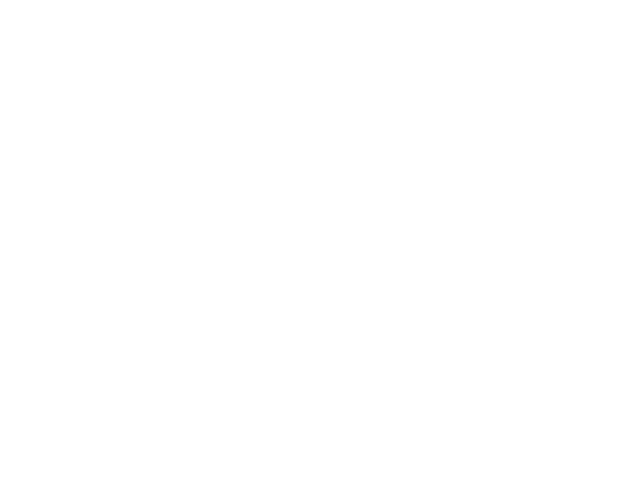

Gratings - apertured size: 30
Blobs - min/max size: (10, 50)
('stimuli presented @:', 20.0, -8.0)


<IPython.core.display.Javascript object>


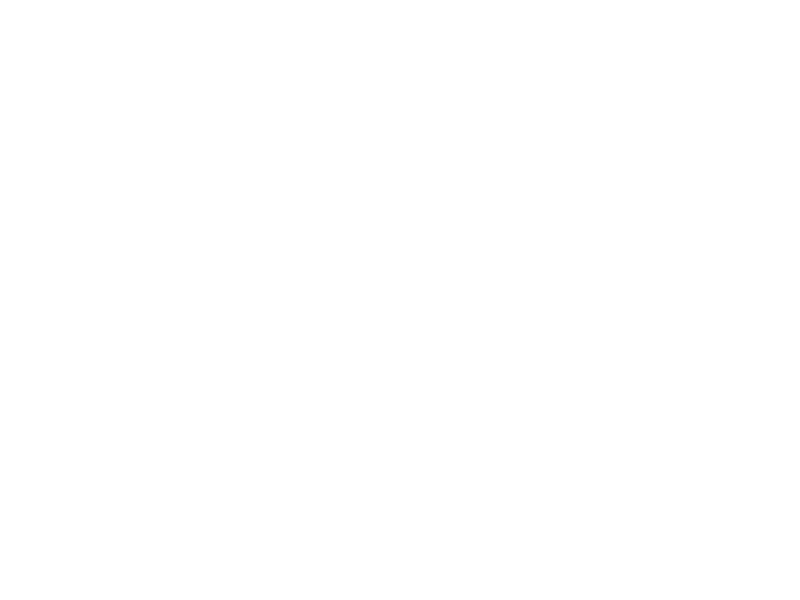

Li JC091
... creating new session object
[JC091] 20190606 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... new session object to: /n/coxfs01/2p-data/JC091/20190606/FOV1_zoom2p0x/summaries/sessiondata.pkl
('... got session object w/ experiments:', {})
('Found 4 experiments in current session:', ['rfs10', 'gratings', 'blobs', 'retino'])
Calculating stats
[rfs10] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'rfs10')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (rfs10 - traces001 - corrected)
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... [JC091|20190606|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... loading data array
/n/coxfs01/2p-data/JC091/20190606/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_05849a_traces001_593095_

Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1010, in load
    traceid=self.traceid)
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


... ... got rois
... [JC091|20190606|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... loading data array
/n/coxfs01/2p-data/JC091/20190606/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_d22d1d_traces001_33c6c3_traces001_001228_traces001_bcad83/data_arrays/np_subtracted.npz
adding NP offset...
... updating self
... ... loaded traces
... gratings: calculating stats
... [combined_gratings_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
[blobs] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'blobs')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (blobs - traces001 - corrected)
('... Getting experiment data:', ['blobs'])
... ... loading: blobs
... ... got rois
... [JC091|20190606|FOV1_zoom2p0x] creating blobs object
... ge

<IPython.core.display.Javascript object>


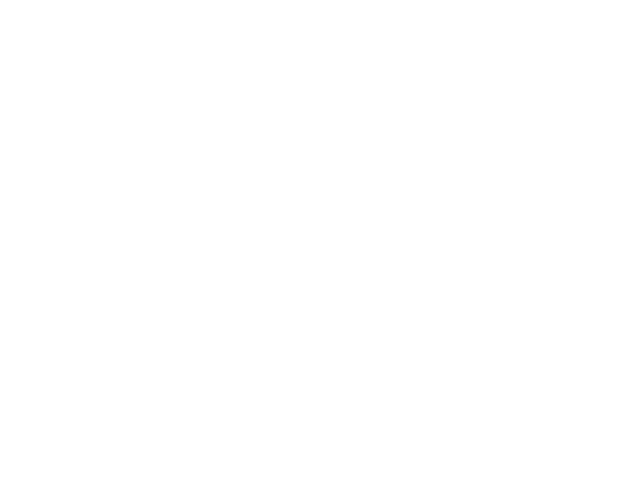

Gratings - apertured size: 30
Blobs - min/max size: (10, 50)
('stimuli presented @:', 20.0, -8.0)


<IPython.core.display.Javascript object>


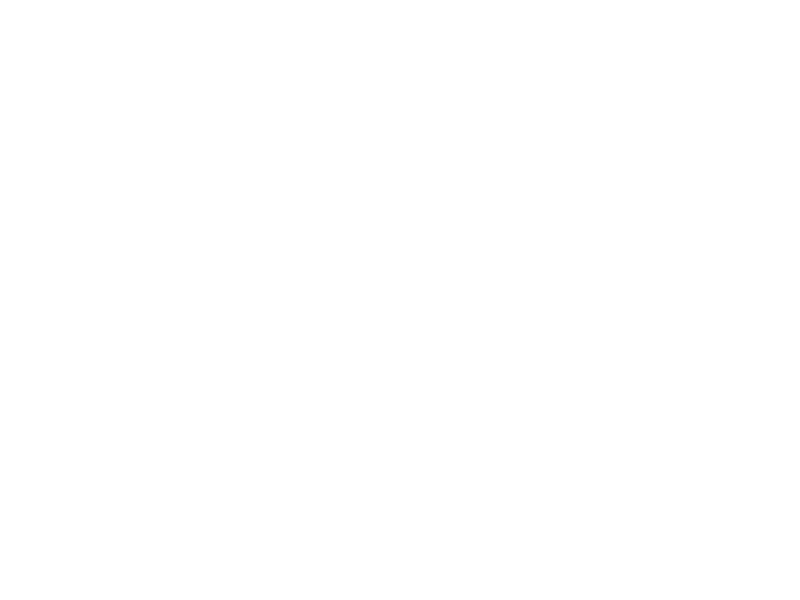

Li JC091
... creating new session object
[JC091] 20190607 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... new session object to: /n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0x/summaries/sessiondata.pkl
('... got session object w/ experiments:', {})
('Found 4 experiments in current session:', ['rfs10', 'gratings', 'blobs', 'retino'])
Calculating stats
[rfs10] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'rfs10')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (rfs10 - traces001 - corrected)
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... [JC091|20190607|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... loading data array
/n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_37d16e_traces001_638646_

Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1010, in load
    traceid=self.traceid)
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


[gratings] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'gratings')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (gratings - traces001 - corrected)
('... Getting experiment data:', ['gratings'])
... ... loading: gratings
... ... got rois
... [JC091|20190607|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... loading data array
/n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_ebd3ed_traces001_72fc42_traces001_72d3d2_traces001_1a54cd/data_arrays/np_subtracted.npz
adding NP offset...
... updating self
... ... loaded traces
... gratings: calculating stats
... [combined_gratings_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
[blobs] Loading roi lists...
('Session Object- Getting grouped ro

<IPython.core.display.Javascript object>


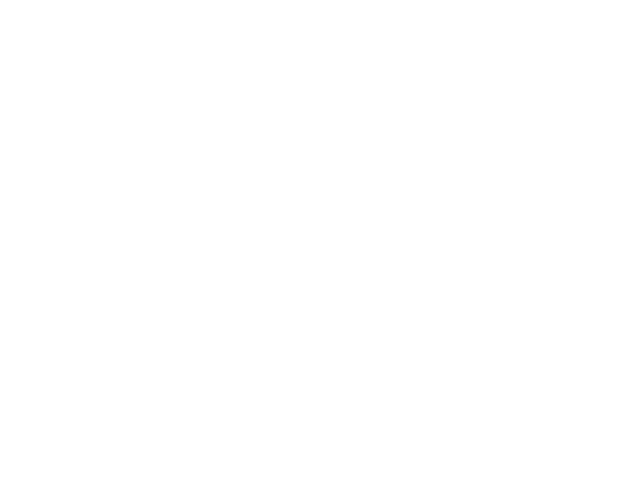

Gratings - apertured size: 30
Blobs - min/max size: (10, 50)
('stimuli presented @:', 20.0, -5.0)


<IPython.core.display.Javascript object>


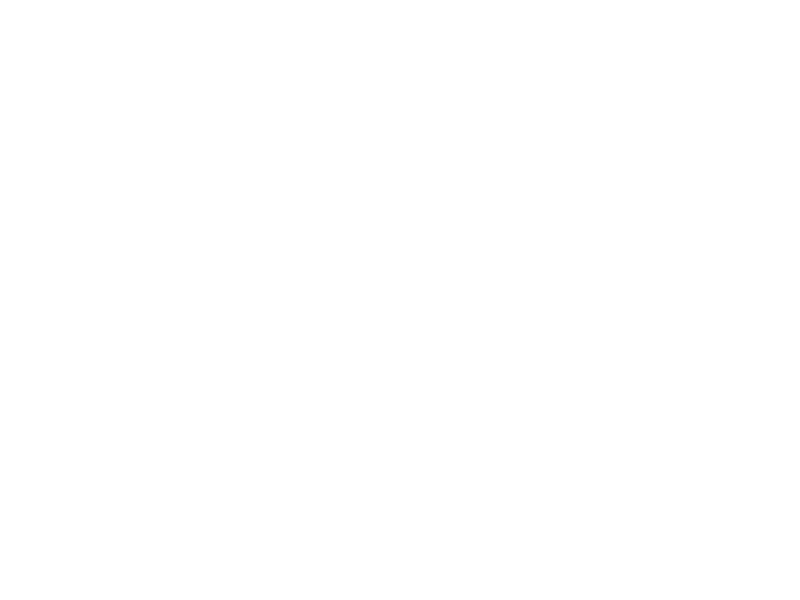

Li JC091
... creating new session object
[JC091] 20190614 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... new session object to: /n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0x/summaries/sessiondata.pkl
('... got session object w/ experiments:', {})
('Found 4 experiments in current session:', ['rfs10', 'gratings', 'blobs', 'retino'])
Calculating stats
[rfs10] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'rfs10')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (rfs10 - traces001 - corrected)
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... [JC091|20190614|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... loading data array
/n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_601a1c_traces001_e2ec1e_

Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1010, in load
    traceid=self.traceid)
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


[gratings] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'gratings')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (gratings - traces001 - corrected)
('... Getting experiment data:', ['gratings'])
... ... loading: gratings
... ... got rois
... [JC091|20190614|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... loading data array
/n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_7dabd5_traces001_55cc1f_traces001_acb6f5_traces001_02c540/data_arrays/np_subtracted.npz
adding NP offset...
... updating self
... ... loaded traces
... gratings: calculating stats
... [combined_gratings_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
[blobs] Loading roi lists...
('Session Object- Getting grouped ro

<IPython.core.display.Javascript object>


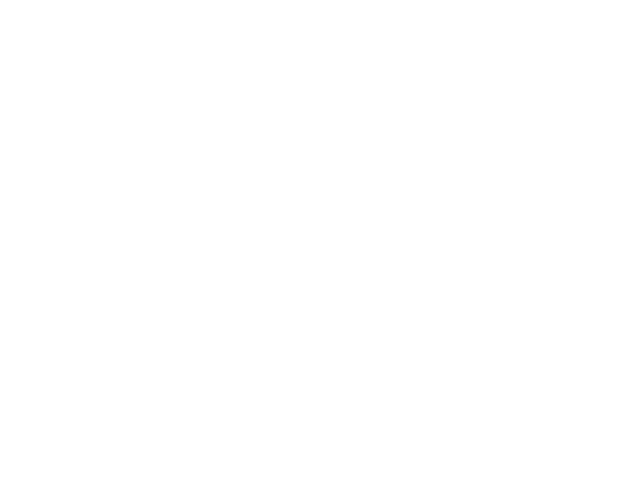

Gratings - apertured size: 30
Blobs - min/max size: (10, 50)
('stimuli presented @:', 10.0, -5.0)


<IPython.core.display.Javascript object>


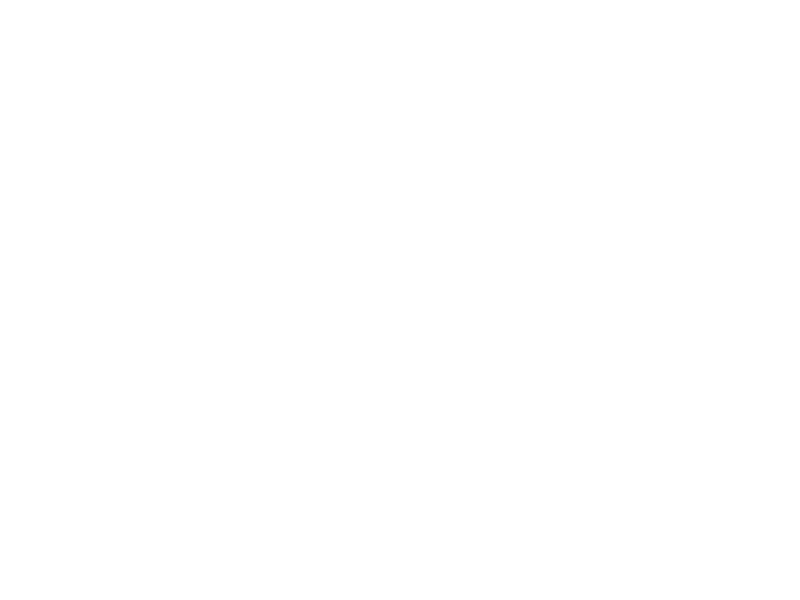

Li JC091
... creating new session object
[JC091] 20191008 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC091 | 20191008 | FOV1_zoom2p0x)
... Getting screen info
... new session object to: /n/coxfs01/2p-data/JC091/20191008/FOV1_zoom2p0x/summaries/sessiondata.pkl
('... got session object w/ experiments:', {})
('Found 4 experiments in current session:', ['rfs10', 'gratings', 'blobs', 'retino'])
Calculating stats
[rfs10] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'rfs10')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (rfs10 - traces001 - corrected)
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... [JC091|20191008|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... loading data array
/n/coxfs01/2p-data/JC091/20191008/FOV1_zoom2p0x/combined_rfs10_static

<IPython.core.display.Javascript object>


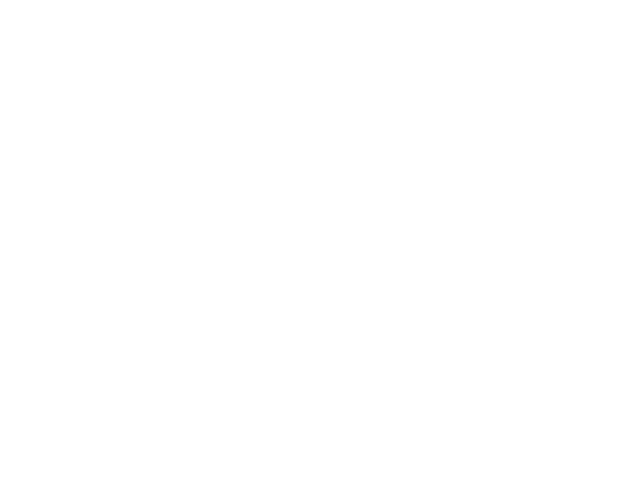

Gratings - apertured size: 30
Blobs - min/max size: (10, 50)
('stimuli presented @:', 20.0, -10.0)


<IPython.core.display.Javascript object>


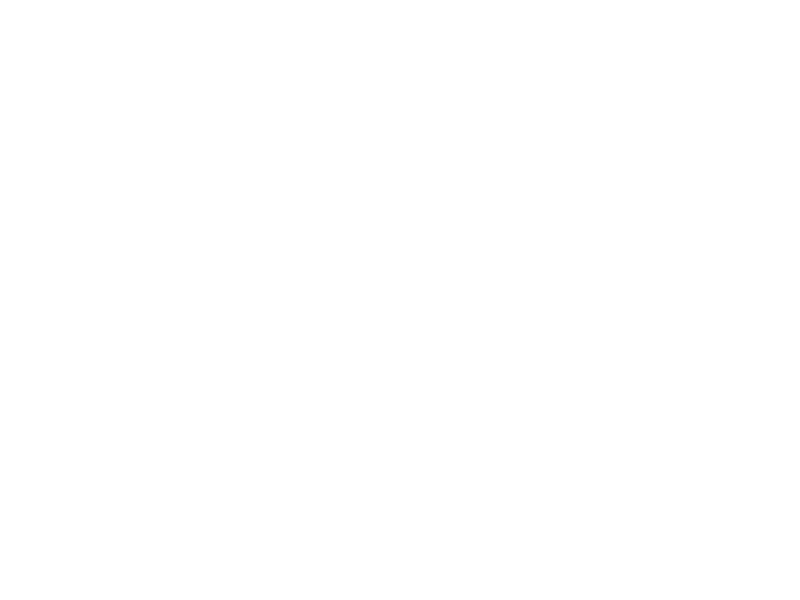

Li JC099
... creating new session object
[JC099] 20190609 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... new session object to: /n/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0x/summaries/sessiondata.pkl
('... got session object w/ experiments:', {})
('Found 5 experiments in current session:', ['rfs10', 'gratings', 'blobs', 'retino', 'dynblobs'])
Calculating stats
[rfs10] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'rfs10')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (rfs10 - traces001 - corrected)
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... [JC099|20190609|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... loading data array
/n/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_f96aeb_trace

Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1010, in load
    traceid=self.traceid)
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


[gratings] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'gratings')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (gratings - traces001 - corrected)
('... Getting experiment data:', ['gratings'])
... ... loading: gratings
... ... got rois
... [JC099|20190609|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... loading data array
/n/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_3df331_traces001_4f5354_traces001_97e1ee_traces001_2625ca/data_arrays/np_subtracted.npz
adding NP offset...
... updating self
... ... loaded traces
... gratings: calculating stats
... [combined_gratings_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
[blobs] Loading roi lists...
('Session Object- Getting grouped ro

<IPython.core.display.Javascript object>


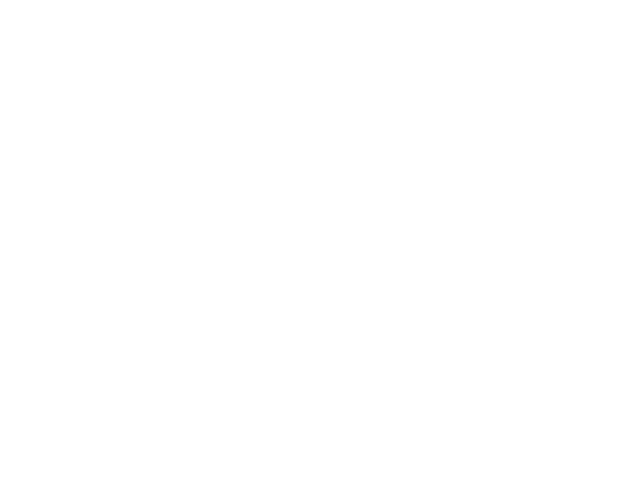

Gratings - apertured size: 30
Blobs - min/max size: (10, 50)
('stimuli presented @:', 30.0, -5.0)


<IPython.core.display.Javascript object>


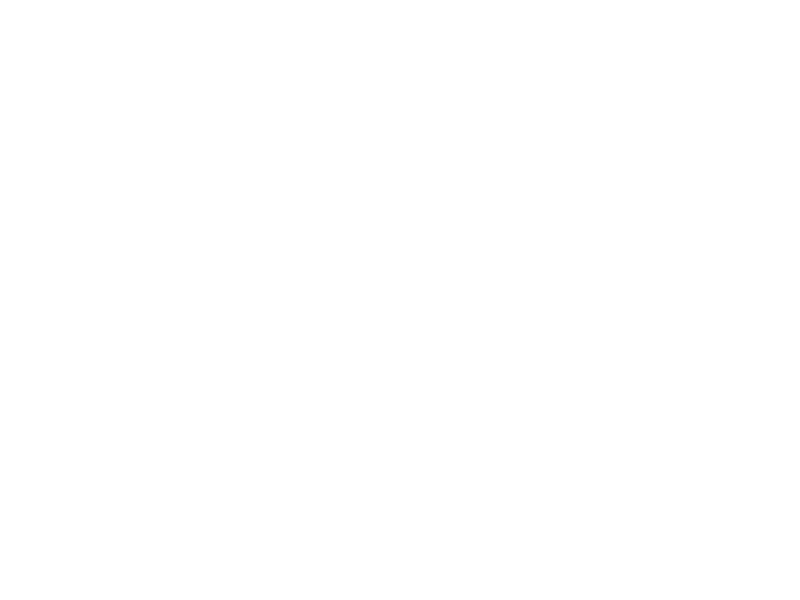

Li JC099
... creating new session object
[JC099] 20190612 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... new session object to: /n/coxfs01/2p-data/JC099/20190612/FOV1_zoom2p0x/summaries/sessiondata.pkl
('... got session object w/ experiments:', {})
('Found 4 experiments in current session:', ['rfs10', 'gratings', 'blobs', 'retino'])
Calculating stats
[rfs10] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'rfs10')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (rfs10 - traces001 - corrected)
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... [JC099|20190612|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... loading data array
/n/coxfs01/2p-data/JC099/20190612/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_c582b7_traces001_d52cff_

Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1010, in load
    traceid=self.traceid)
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


[gratings] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'gratings')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (gratings - traces001 - corrected)
('... Getting experiment data:', ['gratings'])
... ... loading: gratings
... ... got rois
... [JC099|20190612|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... loading data array
/n/coxfs01/2p-data/JC099/20190612/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_0b642c_traces001_eaaf9d_traces001_d97b36_traces001_2d4a72/data_arrays/np_subtracted.npz
adding NP offset...
... updating self
... ... loaded traces
... gratings: calculating stats
... [combined_gratings_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
[blobs] Loading roi lists...
('Session Object- Getting grouped ro

<IPython.core.display.Javascript object>


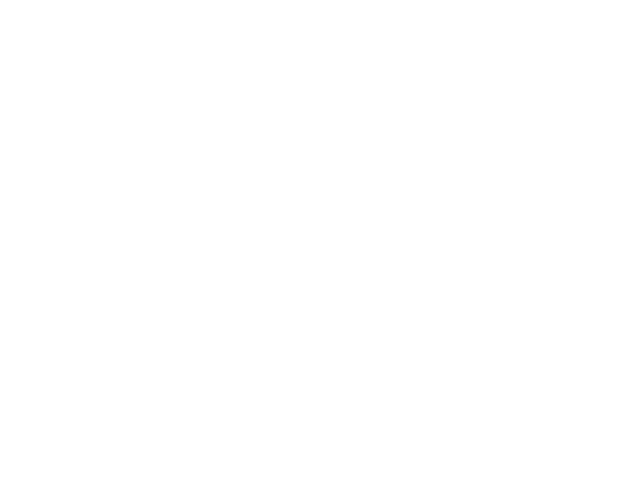

Gratings - apertured size: 30
Blobs - min/max size: (10, 50)
('stimuli presented @:', 30.0, -5.0)


<IPython.core.display.Javascript object>


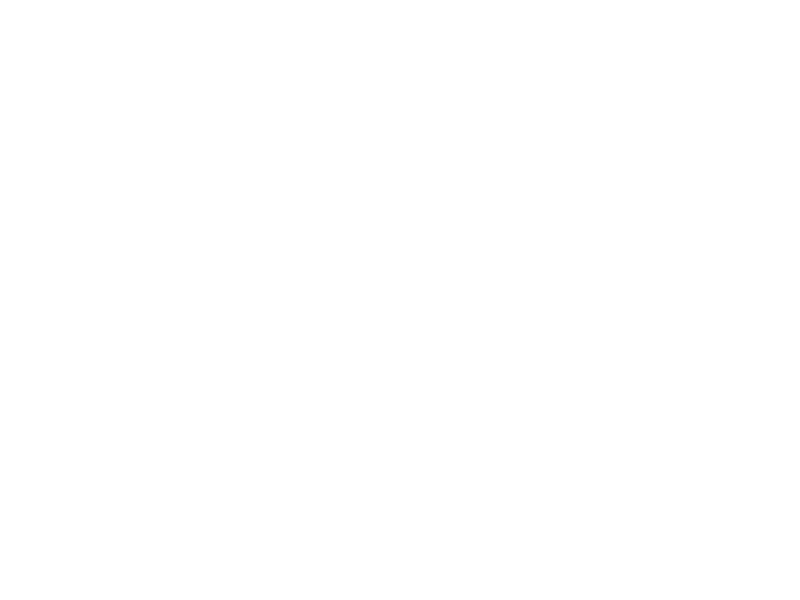

Li JC099
... creating new session object
[JC099] 20190617 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... new session object to: /n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/summaries/sessiondata.pkl
('... got session object w/ experiments:', {})
('Found 4 experiments in current session:', ['rfs10', 'gratings', 'blobs', 'retino'])
Calculating stats
[rfs10] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'rfs10')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (rfs10 - traces001 - corrected)
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... [JC099|20190617|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... loading data array
/n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_8577f8_traces001_abea5d_

Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1010, in load
    traceid=self.traceid)
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


... ... got rois
... [JC099|20190617|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... loading data array
/n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_585a7e_traces001_864059_traces001_9119e0_traces001_eb3372/data_arrays/np_subtracted.npz
adding NP offset...
... updating self
... ... loaded traces
... gratings: calculating stats
... [combined_gratings_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
[blobs] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'blobs')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (blobs - traces001 - corrected)
('... Getting experiment data:', ['blobs'])
... ... loading: blobs
... ... got rois
... [JC099|20190617|FOV1_zoom2p0x] creating blobs object
... ge

<IPython.core.display.Javascript object>


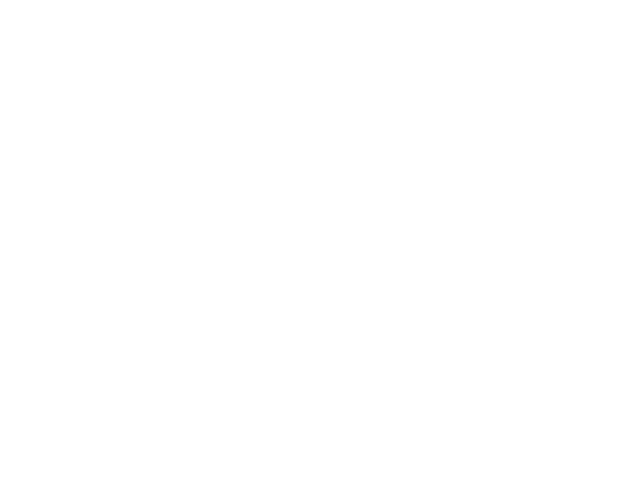

Gratings - apertured size: 30
Blobs - min/max size: (10, 50)
('stimuli presented @:', 25.0, -5.0)


<IPython.core.display.Javascript object>


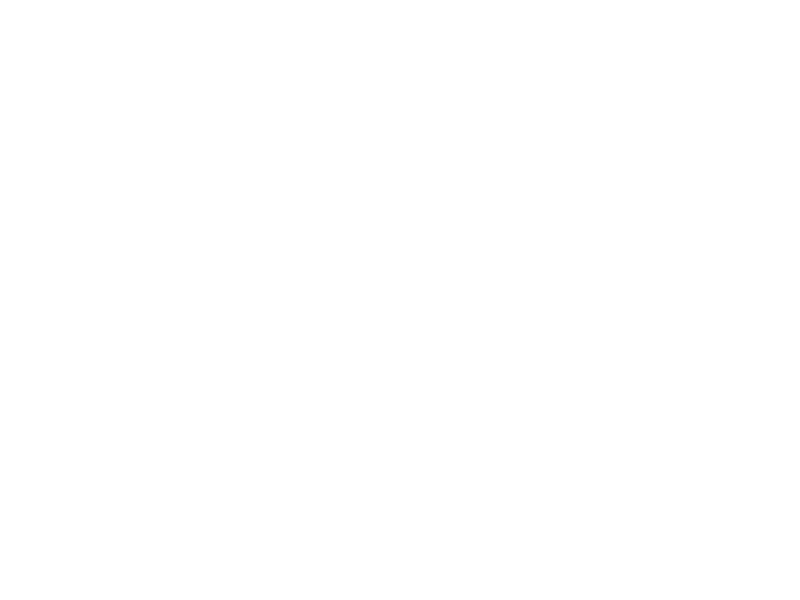

Lm JC078
... creating new session object
[JC078] 20190426 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... new session object to: /n/coxfs01/2p-data/JC078/20190426/FOV1_zoom2p0x/summaries/sessiondata.pkl
('... got session object w/ experiments:', {})
('Found 3 experiments in current session:', ['blobs', 'retino', 'rfs'])
Calculating stats
[blobs] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'blobs')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (blobs - traces001 - corrected)
('... Getting experiment data:', ['blobs'])
... ... loading: blobs
... ... got rois
... [JC078|20190426|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... loading data array
/n/coxfs01/2p-data/JC078/20190426/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_6b44d4_traces001_9b1a10/data_arrays/np

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -402.69531167659807
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -411.08759469696975
STIM TYPE: image
**** File 11 of 40 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190426/FOV1_zoom2p0x/blobs_run2
N tsecs: 3706
There are 200 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3500
... N unique frames: 3500
... Last frame to align: 3704 (N frames total, 3706)
... N tstamps: 3706
N frames per trial: 175
N tstamps: 3500
N trials in block: 20
('Excluding:', [u'filehash', u'filepath'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -229.11922141119248
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -516.4370396082007
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -651.2071329752605
STIM TYPE: image
**** File 12 of 40 *****
*** Excluding: []
/n/coxfs01/2p-data/JC

Frame indices are NOT block indexed
... N frames to align: 3500
... N unique frames: 3500
... Last frame to align: 3703 (N frames total, 3706)
... N tstamps: 3706
N frames per trial: 175
N tstamps: 3500
N trials in block: 20
('Excluding:', [u'filehash', u'filepath'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -97.16092715231753
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -424.67135587651626
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -401.47104344223476
STIM TYPE: image
**** File 23 of 40 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190426/FOV1_zoom2p0x/blobs_run3
N tsecs: 3706
There are 200 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3500
... N unique frames: 3500
... Last frame to align: 3704 (N frames total, 3706)
... N tstamps: 3706
N frames per trial: 175
N tstamps: 3500
N trials in block: 20
('Excluding:', [u'filehash', u'filepath'])


Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -94.41316931982578
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -706.6897059228095
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -616.2692945075759
STIM TYPE: image
**** File 34 of 40 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190426/FOV1_zoom2p0x/blobs_run4
N tsecs: 3706
There are 200 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3500
... N unique frames: 3500
... Last frame to align: 3703 (N frames total, 3706)
... N tstamps: 3706
N frames per trial: 175
N tstamps: 3500
N trials in block: 20
('Excluding:', [u'filehash', u'filepath'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -153.91931540342284
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -590.3607748045387
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -615.9641

<IPython.core.display.Javascript object>


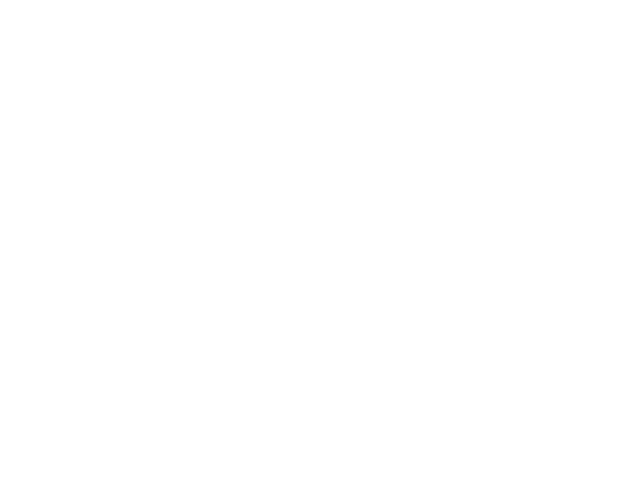

No localized gratings
Blobs - min/max size: (10, 50)
('stimuli presented @:', 30.0, 8.0)


<IPython.core.display.Javascript object>


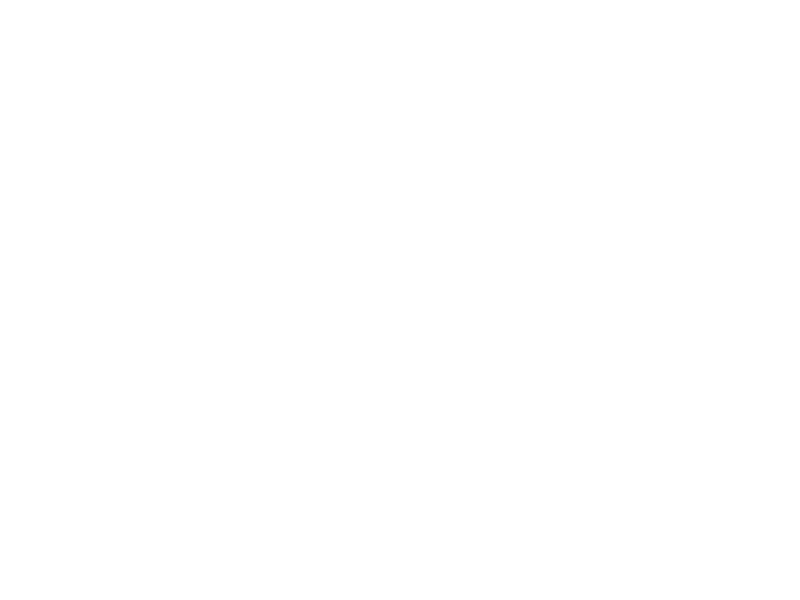

Lm JC078
... creating new session object
[JC078] 20190430 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... new session object to: /n/coxfs01/2p-data/JC078/20190430/FOV1_zoom2p0x/summaries/sessiondata.pkl
('... got session object w/ experiments:', {})
('Found 3 experiments in current session:', ['blobs', 'retino', 'rfs'])
Calculating stats
[blobs] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'blobs')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (blobs - traces001 - corrected)
('... Getting experiment data:', ['blobs'])
... ... loading: blobs
... ... got rois
... [JC078|20190430|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... loading data array
/n/coxfs01/2p-data/JC078/20190430/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_dfb5b6_traces001_929bd6_traces001_383b

<IPython.core.display.Javascript object>


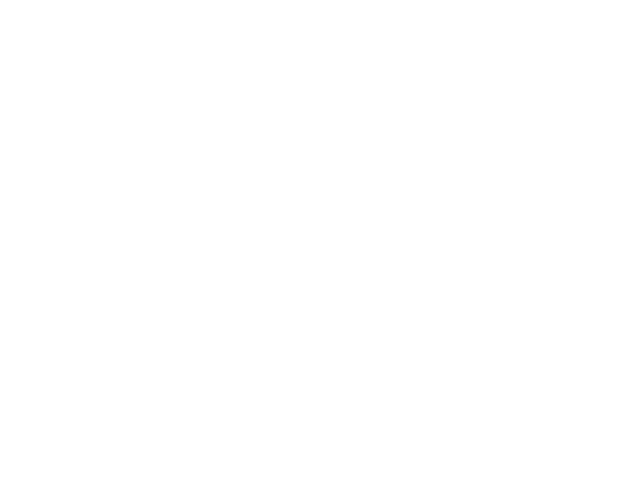

No localized gratings
Blobs - min/max size: (10, 50)
('stimuli presented @:', 20.0, 0.0)


<IPython.core.display.Javascript object>


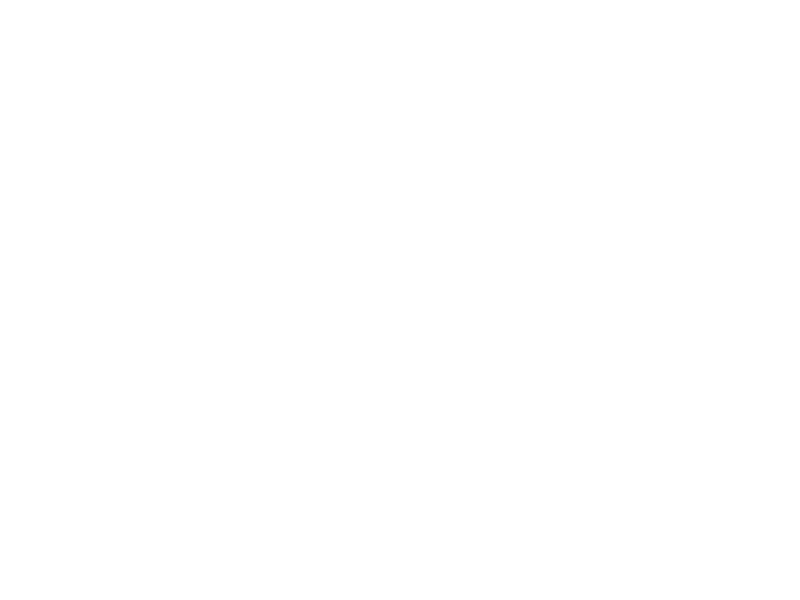

Lm JC078
... creating new session object
[JC078] 20190504 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... new session object to: /n/coxfs01/2p-data/JC078/20190504/FOV1_zoom2p0x/summaries/sessiondata.pkl
('... got session object w/ experiments:', {})
('Found 3 experiments in current session:', ['blobs', 'retino', 'rfs'])
Calculating stats
[blobs] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'blobs')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (blobs - traces001 - corrected)
('... Getting experiment data:', ['blobs'])
... ... loading: blobs
... ... got rois
... [JC078|20190504|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... loading data array
/n/coxfs01/2p-data/JC078/20190504/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_830af1_traces001_241385_traces001_4f57

<IPython.core.display.Javascript object>


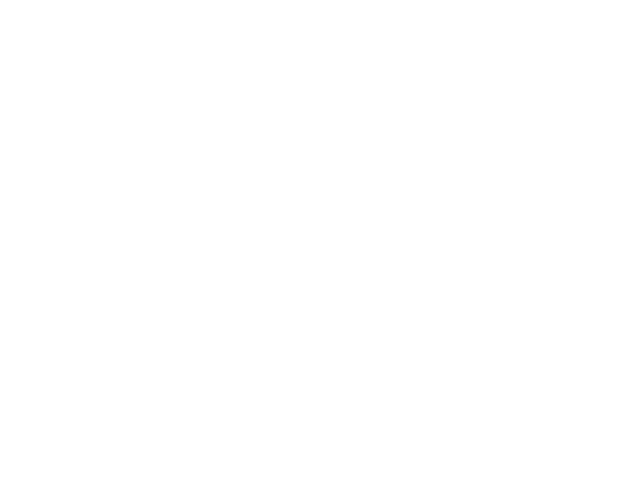

No localized gratings
Blobs - min/max size: (10, 50)
('stimuli presented @:', 30.0, 8.0)


<IPython.core.display.Javascript object>


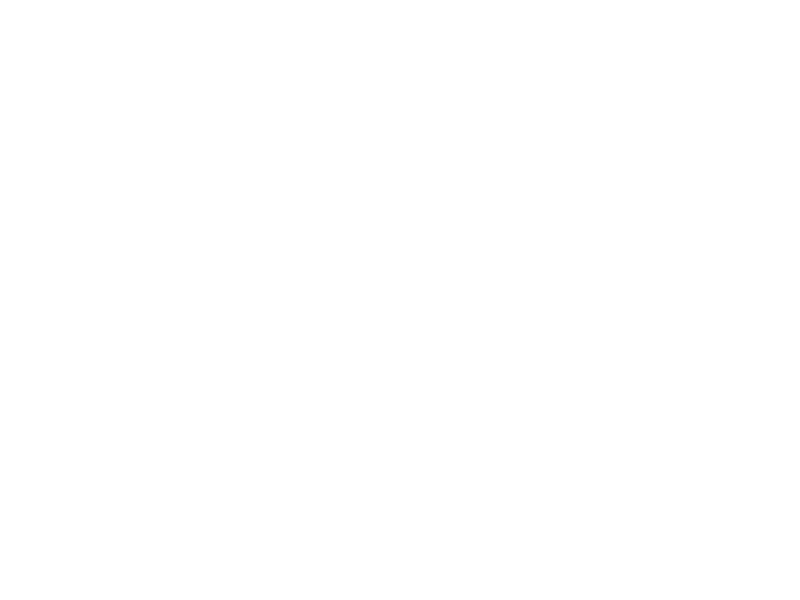

Lm JC078
... creating new session object
[JC078] 20190509 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC078 | 20190509 | FOV1_zoom2p0x)
... Getting screen info
... new session object to: /n/coxfs01/2p-data/JC078/20190509/FOV1_zoom2p0x/summaries/sessiondata.pkl
('... got session object w/ experiments:', {})
('Found 3 experiments in current session:', ['blobs', 'retino', 'rfs'])
Calculating stats
[blobs] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'blobs')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (blobs - traces001 - corrected)
('... Getting experiment data:', ['blobs'])
... ... loading: blobs
... ... got rois
... [JC078|20190509|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... loading data array
/n/coxfs01/2p-data/JC078/20190509/FOV1_zoom2p0x/combined_blobs_static/traces/traces

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -61.65484180249274
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -187.48533746926137
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -183.40503669507586
STIM TYPE: gratings
**** File 8 of 64 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190509/FOV1_zoom2p0x/gratings_run1
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 7 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -54.43246839654046
Showing initial drift correction (quantile: 0.10)

Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 5 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -56.91803278688485
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -255.22229248799715
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -267.0757751464844
STIM TYPE: gratings
**** File 18 of 64 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190509/FOV1_zoom2p0x/gratings_run2
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 6 (has 2911 frames)
... asking for 12 extr

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -257.5333820066453
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -254.2913651315789
STIM TYPE: gratings
**** File 27 of 64 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190509/FOV1_zoom2p0x/gratings_run3
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 4 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -57.17088607594917
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -259.72705043859696
Showing initial drift correction (quantile: 0.10)

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -68.831391363948
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -323.97464445033904
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -318.1313709077381
STIM TYPE: gratings
**** File 37 of 64 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190509/FOV1_zoom2p0x/gratings_run4
N tsecs: 2911
There are 378 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 3 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -66.33378016085783
Showing initial drift correction (quantile: 0.10)
M

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -54.023104265402935
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -239.14938104984924
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -261.7656931322674
STIM TYPE: gratings
**** File 47 of 64 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190509/FOV1_zoom2p0x/gratings_run5
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 4 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -46.75420673076928
Showing initial drift correction (quantile: 0.10

Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 2 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -65.95918367346951
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -204.51736898100057
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -202.8975380345397
STIM TYPE: gratings
**** File 57 of 64 *****
*** Excluding: []
/n/coxfs01/2p-data/JC078/20190509/FOV1_zoom2p0x/gratings_run6
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 3 (has 2911 frames)
... asking for 11 extr

np_subtracted
Saving labels data... /n/coxfs01/2p-data/JC078/20190509/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_d23a2d_traces001_25d81e_traces001_87d19b_traces001_60f54c_traces001_b49cb0_traces001_70359a/data_arrays/np_subtracted.npz
raw
Saving labels data... /n/coxfs01/2p-data/JC078/20190509/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_d23a2d_traces001_25d81e_traces001_87d19b_traces001_60f54c_traces001_b49cb0_traces001_70359a/data_arrays/raw.npz
*****corrected offsets!*****
adding NP offset...
... adjusting for equal reps / condn...
... updating self
... ... loaded traces
... rfs: calculating stats
... loading existing stats
Saved stats to file: /n/coxfs01/2p-data/JC078/20190509/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-nstds-thr-10.00/sessionstats_stats-traces001-corrected-dff-nstds-thr-10.00.pkl
x-/y-res: 5, 5
[JC078|20190509] No experiment exists for: gratings
Stimuli presented at coords: (30, 8)
... getting fov info
Created 295 contours for roi

<IPython.core.display.Javascript object>


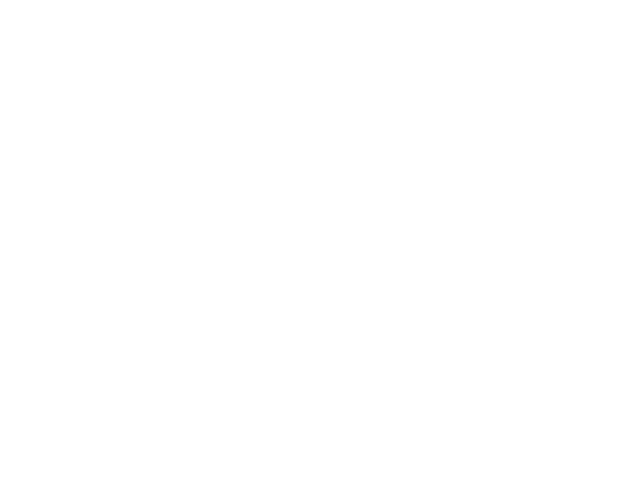

No localized gratings
Blobs - min/max size: (10, 50)
('stimuli presented @:', 30.0, 8.0)


<IPython.core.display.Javascript object>


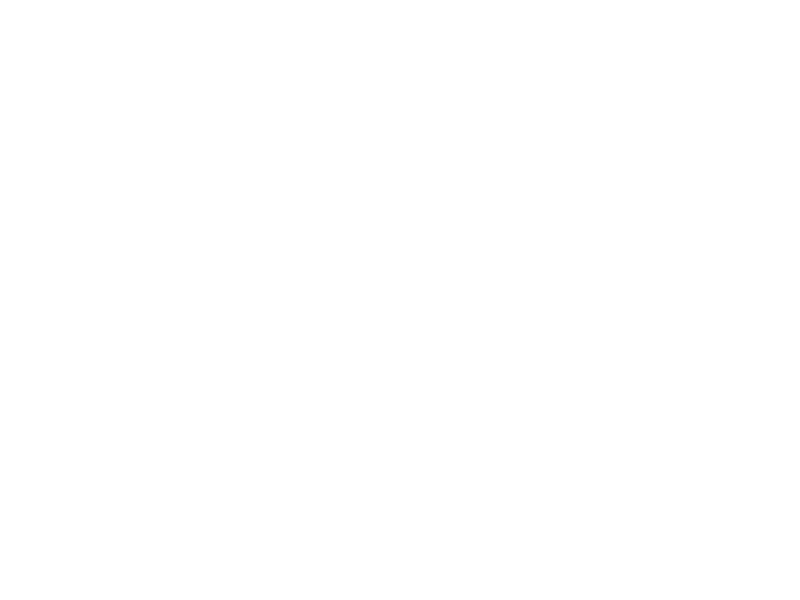

Lm JC078
... creating new session object
[JC078] 20190513 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC078 | 20190513 | FOV1_zoom2p0x)
... Getting screen info
... new session object to: /n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/summaries/sessiondata.pkl
('... got session object w/ experiments:', {})
('Found 4 experiments in current session:', ['rfs', 'gratings', 'blobs', 'retino'])
Calculating stats
[rfs] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'rfs')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (rfs - traces001 - corrected)
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... [JC078|20190513|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... loading data array
/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_15

<IPython.core.display.Javascript object>


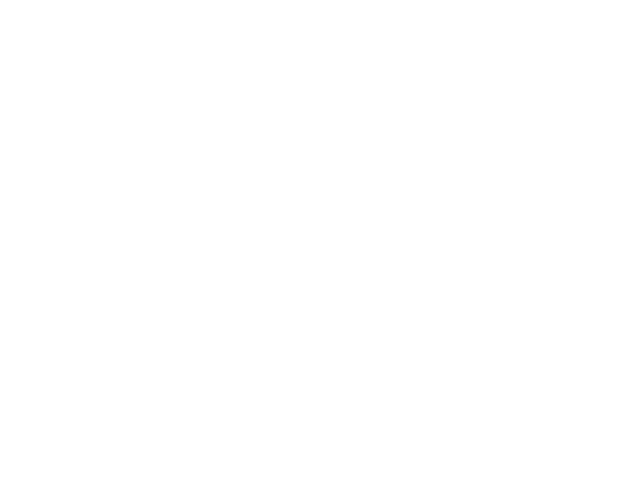

Gratings - apertured size: 30
Blobs - min/max size: (10, 50)
('stimuli presented @:', 20.0, 0.0)


<IPython.core.display.Javascript object>


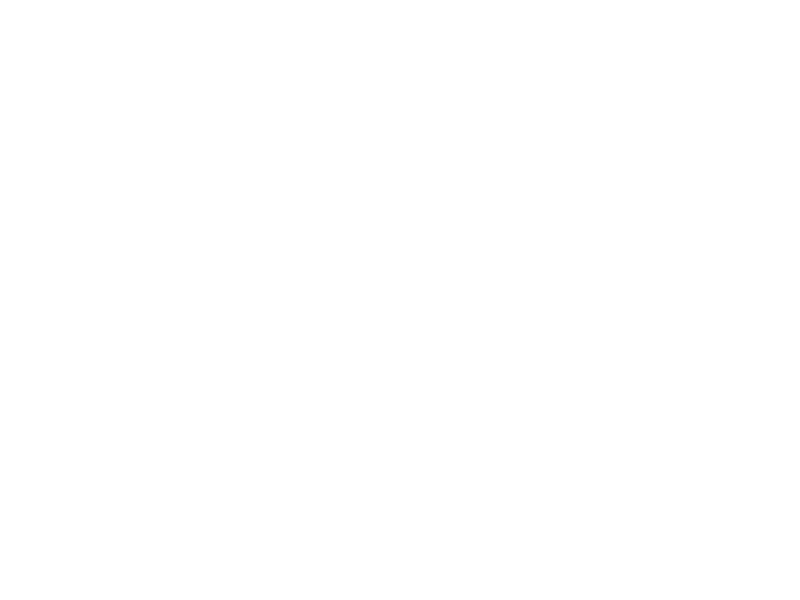

Lm JC080
... creating new session object
[JC080] 20190506 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... new session object to: /n/coxfs01/2p-data/JC080/20190506/FOV1_zoom2p0x/summaries/sessiondata.pkl
('... got session object w/ experiments:', {})
('Found 3 experiments in current session:', ['blobs', 'retino', 'rfs'])
Calculating stats
[blobs] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'blobs')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (blobs - traces001 - corrected)
('... Getting experiment data:', ['blobs'])
... ... loading: blobs
... ... got rois
... [JC080|20190506|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... loading data array
/n/coxfs01/2p-data/JC080/20190506/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_8a95b0_traces001_ba1965_traces001_f4a7

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -97.94588744588759
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -363.75153477522736
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -433.8807586984535
STIM TYPE: gratings
**** File 8 of 59 *****
*** Excluding: []
/n/coxfs01/2p-data/JC080/20190506/FOV1_zoom2p0x/gratings_run1
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 7 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -84.84244946492231
Showing initial drift correction (quantile: 0.10)


Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -82.70165016501642
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -226.03015226275886
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -244.75634765625034
STIM TYPE: gratings
**** File 18 of 59 *****
*** Excluding: []
/n/coxfs01/2p-data/JC080/20190506/FOV1_zoom2p0x/gratings_run2
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 6 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -110.22526041666663
Showing initial drift correction (quantile: 0.1

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -100.80428571428638
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -255.18592208059226
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -281.23463199013133
STIM TYPE: gratings
**** File 28 of 59 *****
*** Excluding: []
/n/coxfs01/2p-data/JC080/20190506/FOV1_zoom2p0x/gratings_run3
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 5 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -64.33709869203335
Showing initial drift correction (quantile: 0.1

... N frames to align: 3471
... N unique frames: 2690
... Last frame to align: 2717 (N frames total, 2911)
... N tstamps: 2911
N frames per trial: 89
N tstamps: 3471
N trials in block: 39
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -77.291015625
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -427.9263049229296
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -488.3436493234533
STIM TYPE: gratings
**** File 38 of 59 *****
*** Excluding: []
/n/coxfs01/2p-data/JC080/20190506/FOV1_zoom2p0x/gratings_run5
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 0 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 8

Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 9 (has 2911 frames)
... asking for 10 extra frames...
... Last frame to align: 2921 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -90.81428571428546
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -246.9176966619989
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -287.8124441964287
STIM TYPE: gratings
**** File 48 of 59 *****
*** Excluding: []
/n/coxfs01/2p-data/JC080/20190506/FOV1_zoom2p0x/gratings_run5
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 10 (has 2911 frames)
... asking for 11 extr

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -364.68498370588895
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -392.4910397873723
STIM TYPE: gratings
**** File 57 of 59 *****
*** Excluding: []
/n/coxfs01/2p-data/JC080/20190506/FOV1_zoom2p0x/gratings_run6
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 8 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -80.67657550535091
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -407.2534161875501
Showing initial drift correction (quantile: 0.10)

<IPython.core.display.Javascript object>


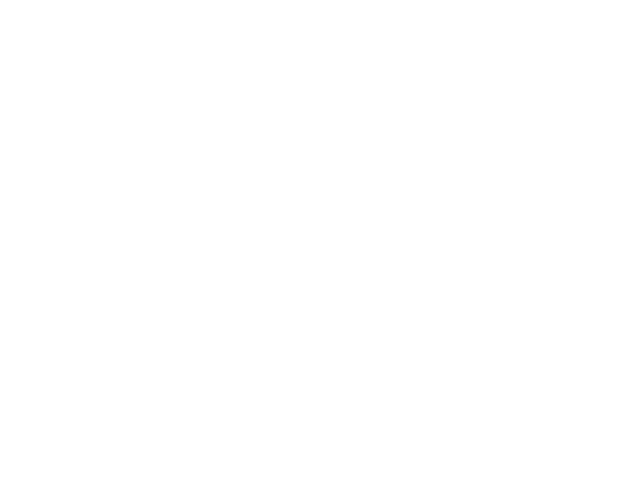

No localized gratings
Blobs - min/max size: (10, 50)
('stimuli presented @:', 15.0, 8.0)


<IPython.core.display.Javascript object>


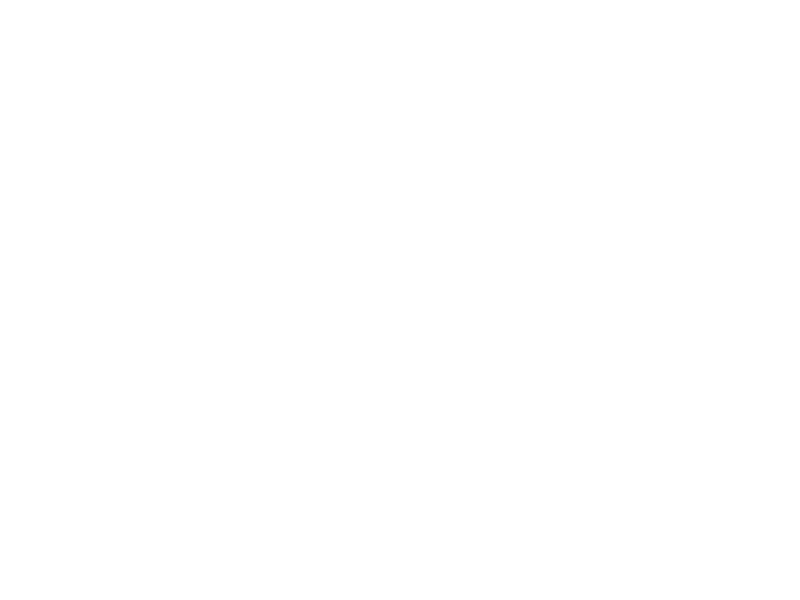

Lm JC080
... creating new session object
[JC080] 20190603 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... new session object to: /n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0x/summaries/sessiondata.pkl
('... got session object w/ experiments:', {})
('Found 4 experiments in current session:', ['rfs', 'gratings', 'blobs', 'retino'])
Calculating stats
[rfs] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'rfs')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (rfs - traces001 - corrected)
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... [JC080|20190603|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... loading data array
/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_48087b_traces001_eb1ab1_traces001_34291b_tra

<IPython.core.display.Javascript object>


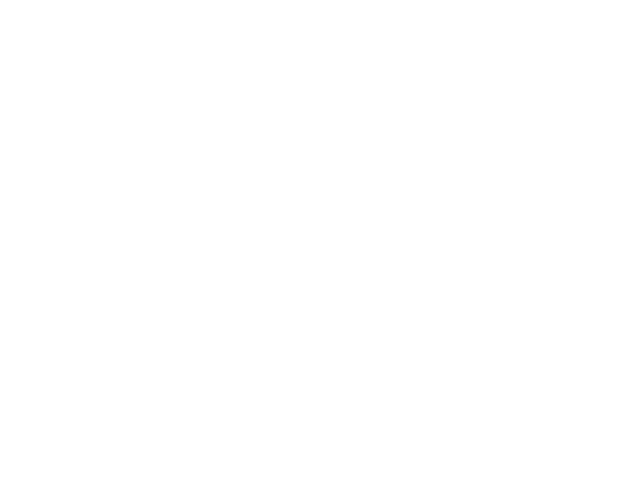

Gratings - apertured size: 30
Blobs - min/max size: (10, 50)
('stimuli presented @:', 15.0, 8.0)


<IPython.core.display.Javascript object>


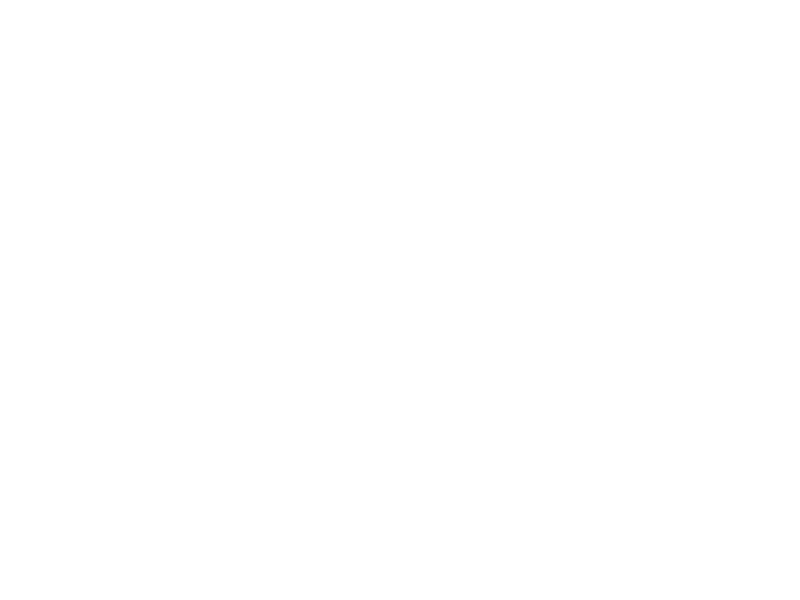

Lm JC083
... creating new session object
[JC083] 20190508 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC083 | 20190508 | FOV1_zoom2p0x)
... Getting screen info
... new session object to: /n/coxfs01/2p-data/JC083/20190508/FOV1_zoom2p0x/summaries/sessiondata.pkl
('... got session object w/ experiments:', {})
('Found 3 experiments in current session:', ['blobs', 'retino', 'rfs'])
Calculating stats
[blobs] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'blobs')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (blobs - traces001 - corrected)
('... Getting experiment data:', ['blobs'])
... ... loading: blobs
... ... got rois
... [JC083|20190508|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... loading data array
/n/coxfs01/2p-data/JC083/20190508/FOV1_zoom2p0x/combined_blobs_static/traces/traces

<IPython.core.display.Javascript object>


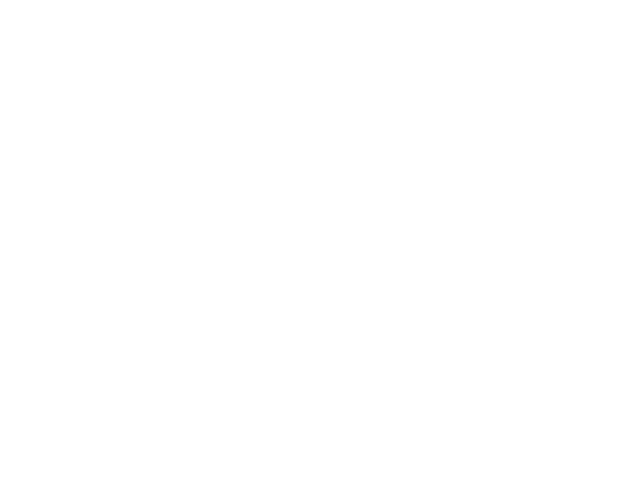

No localized gratings
Blobs - min/max size: (10, 50)
('stimuli presented @:', 20.0, 5.0)


<IPython.core.display.Javascript object>


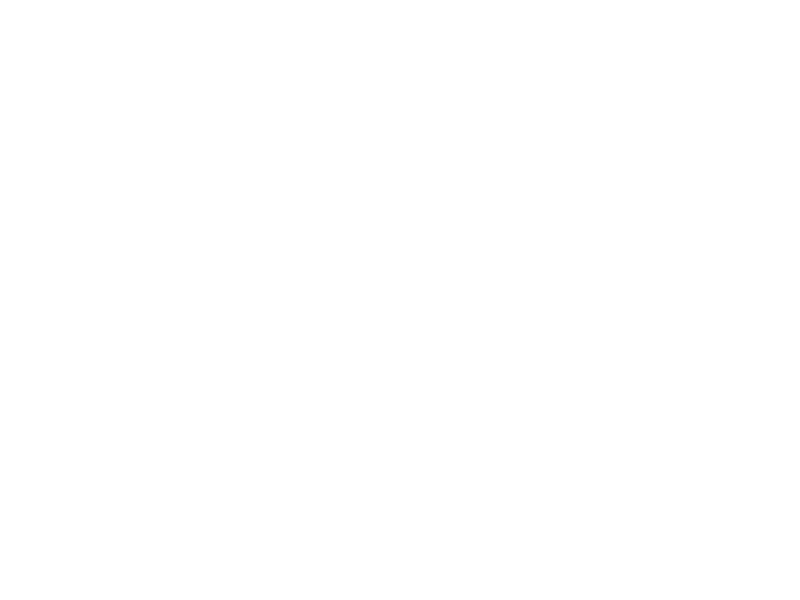

Lm JC083
... creating new session object
[JC083] 20190512 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC083 | 20190512 | FOV1_zoom2p0x)
... Getting screen info
... new session object to: /n/coxfs01/2p-data/JC083/20190512/FOV1_zoom2p0x/summaries/sessiondata.pkl
('... got session object w/ experiments:', {})
('Found 4 experiments in current session:', ['rfs', 'gratings', 'blobs', 'retino'])
Calculating stats
[rfs] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'rfs')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (rfs - traces001 - corrected)
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... [JC083|20190512|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... loading data array
/n/coxfs01/2p-data/JC083/20190512/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_d9

Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 1980
... File: 8 (has 1952 frames)
... asking for 32 extra frames...
... Last frame to align: 1984 (N frames total, 1952)
... N tstamps: 1952
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -74.09495101733228
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -339.83231512146057
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -326.1036358173078
STIM TYPE: gratings
**** File 10 of 88 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190512/FOV1_zoom2p0x/rfs_run1
N tsecs: 1952
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 1981
... File: 9 (has 1952 frames)
... asking for 33 extra fra

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -318.99316406250045
STIM TYPE: gratings
**** File 19 of 88 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190512/FOV1_zoom2p0x/rfs_run2
N tsecs: 1952
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 1981
... File: 7 (has 1952 frames)
... asking for 33 extra frames...
... Last frame to align: 1985 (N frames total, 1952)
... N tstamps: 1952
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -125.8695129284423
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -473.924664909639
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -571.1795673076927
STIM TYPE: gratings
**** File 20 of 88 *****
*** Exclud

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -112.58726270667478
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -701.1316124838972
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -738.3618469238281
STIM TYPE: gratings
**** File 29 of 88 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190512/FOV1_zoom2p0x/rfs_run3
N tsecs: 1952
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 1981
... File: 6 (has 1952 frames)
... asking for 33 extra frames...
... Last frame to align: 1985 (N frames total, 1952)
... N tstamps: 1952
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -77.96319498825392
Showing initial drift correction (quantile: 0.10)
Min 

Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 367, in aggregate_experiment_runs
    frame_shift = 0 if 'block_frame_offset' not in mwinfo[trials_in_block[0]].keys() else mwinfo[trials_in_block[0]]['block_frame_offset']
IndexError: list index out of range


/n/coxfs01/2p-data/JC083/20190512/FOV1_zoom2p0x/rfs_run5
N tsecs: 1952
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 1980
... File: 0 (has 1952 frames)
... asking for 32 extra frames...
... Last frame to align: 1984 (N frames total, 1952)
... N tstamps: 1952
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -123.82694610778469
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -328.26469705746104
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -336.915745192307
STIM TYPE: gratings
**** File 39 of 88 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190512/FOV1_zoom2p0x/rfs_run5
N tsecs: 1952
There are 462 total trials across all .tif files.
Frame indices are NOT bloc

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -619.060356087813
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -603.1898888221153
STIM TYPE: gratings
**** File 48 of 88 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190512/FOV1_zoom2p0x/rfs_run5
N tsecs: 1952
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 1980
... File: 10 (has 1952 frames)
... asking for 32 extra frames...
... Last frame to align: 1984 (N frames total, 1952)
... N tstamps: 1952
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -113.83491847826099
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -341.36779378742494
Showing initial drift correction (quantile: 0.10)
Min

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -66.46640574037838
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -330.9017401818819
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -305.06425781249936
STIM TYPE: gratings
**** File 58 of 88 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190512/FOV1_zoom2p0x/rfs_run7
N tsecs: 1952
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 1980
... File: 0 (has 1952 frames)
... asking for 32 extra frames...
... Last frame to align: 1984 (N frames total, 1952)
... N tstamps: 1952
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -78.63074604370786
Showing initial drift correction (quantile: 0.10)
Min 

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -93.77970627503282
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -268.4144144938034
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -263.7696112961062
STIM TYPE: gratings
**** File 68 of 88 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190512/FOV1_zoom2p0x/rfs_run7
N tsecs: 1952
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 1981
... File: 10 (has 1952 frames)
... asking for 33 extra frames...
... Last frame to align: 1985 (N frames total, 1952)
... N tstamps: 1952
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -72.57003745318343
Showing initial drift correction (quantile: 0.10)
Min 

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -125.70963270963296
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -946.321799879807
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -1026.4271484375
STIM TYPE: gratings
**** File 78 of 88 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190512/FOV1_zoom2p0x/rfs_run9
N tsecs: 1952
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 1981
... File: 0 (has 1952 frames)
... asking for 32 extra frames...
... Last frame to align: 1984 (N frames total, 1952)
... N tstamps: 1952
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -106.06991525423769
Showing initial drift correction (quantile: 0.10)
Min va

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -110.70520833333308
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -981.5305085727532
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -1031.1217548076925
STIM TYPE: gratings
**** File 88 of 88 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190512/FOV1_zoom2p0x/rfs_run9
N tsecs: 1952
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 1981
... File: 10 (has 1952 frames)
... asking for 33 extra frames...
... Last frame to align: 1985 (N frames total, 1952)
... N tstamps: 1952
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -88.55239064089528
Showing initial drift correction (quantile: 0.10)
Mi

<IPython.core.display.Javascript object>


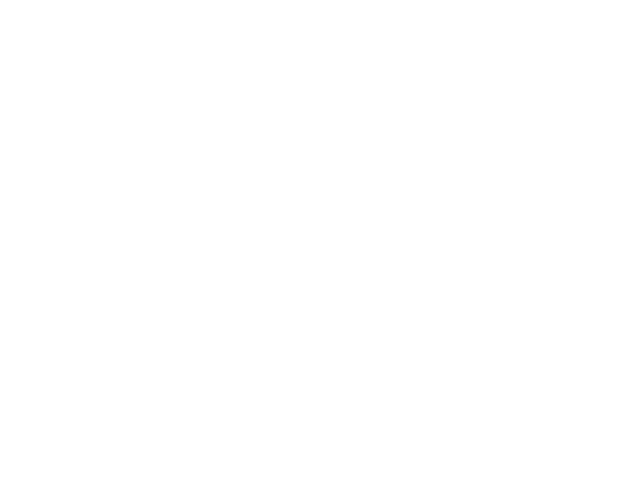

Gratings - apertured size: 30
Blobs - min/max size: (10, 50)
('stimuli presented @:', 20.0, 5.0)


<IPython.core.display.Javascript object>


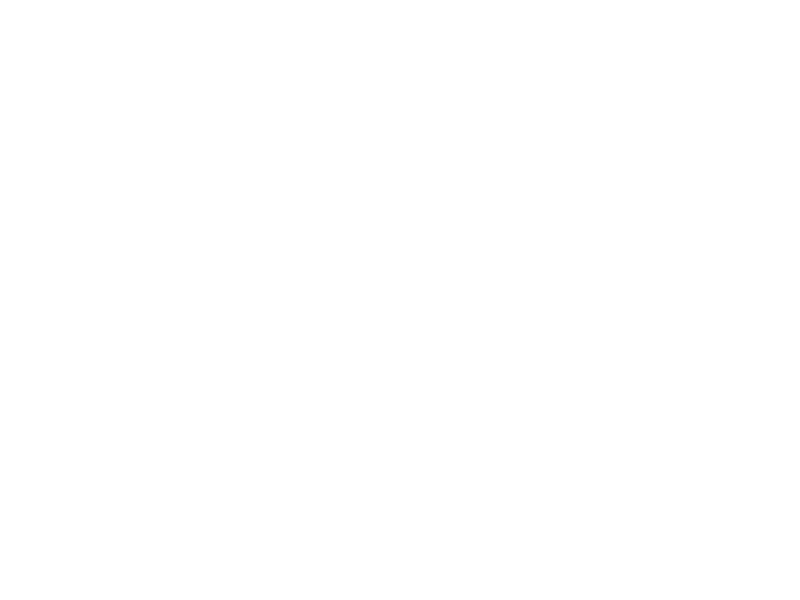

Lm JC083
... creating new session object
[JC083] 20190517 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC083 | 20190517 | FOV1_zoom2p0x)
... Getting screen info
... new session object to: /n/coxfs01/2p-data/JC083/20190517/FOV1_zoom2p0x/summaries/sessiondata.pkl
('... got session object w/ experiments:', {})
('Found 6 experiments in current session:', ['rfs', 'XgratingsX', 'blobs', 'xblobsx', 'gratings', 'retino'])
Calculating stats
[rfs] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'rfs')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (rfs - traces001 - corrected)
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... [JC083|20190517|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... loading data array
/n/coxfs01/2p-data/JC083/20190517/FOV1_zoom2p0x/combined_rfs_s

Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 8 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -92.98990498812373
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -1278.1185139983747
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -1310.0325753348216
STIM TYPE: gratings
**** File 10 of 62 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190517/FOV1_zoom2p0x/rfs_run1
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 9 (has 2911 frames)
... asking for 11 extra fr

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -529.7786038306449
STIM TYPE: gratings
**** File 19 of 62 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190517/FOV1_zoom2p0x/rfs_run2
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 7 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -89.01649601820213
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -586.1482679848953
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -625.6758442540322
STIM TYPE: gratings
**** File 20 of 62 *****
*** Exclud

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -96.15063731170403
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -571.4913634239783
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -544.2201518397173
STIM TYPE: gratings
**** File 29 of 62 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190517/FOV1_zoom2p0x/rfs_run3
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 6 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -81.53880126182946
Showing initial drift correction (quantile: 0.10)
Min v

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -66.84920127795544
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -315.591674880206
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -317.37859122983946
STIM TYPE: gratings
**** File 39 of 62 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190517/FOV1_zoom2p0x/rfs_run4
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 5 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -78.7149478563158
Showing initial drift correction (quantile: 0.10)
Min va

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -102.06883259911888
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -668.599655939445
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -608.4774918094761
STIM TYPE: gratings
**** File 49 of 62 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190517/FOV1_zoom2p0x/rfs_run5
N tsecs: 2911
There are 294 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 4 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -66.30085146641431
Showing initial drift correction (quantile: 0.10)
Min v

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -79.00095602294493
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -294.19812040049067
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -287.6515625000002
STIM TYPE: gratings
**** File 59 of 62 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190517/FOV1_zoom2p0x/rfs_run6
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 7 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -76.2600135777326
Showing initial drift correction (quantile: 0.10)
Min v

adding NP offset...
... adjusting for equal reps / condn...
... updating self
... ... loaded traces
... gratings: calculating stats
... [combined_gratings_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
[retino] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'retino')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (retino - traces001 - corrected)
('... Getting experiment data:', ['retino'])
... ... loading: retino
... ... got rois
Not implemented
Saved stats to file: /n/coxfs01/2p-data/JC083/20190517/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-nstds-thr-10.00/sessionstats_stats-traces001-corrected-dff-nstds-thr-10.00.pkl
x-/y-res: 5, 5
Stimuli presented at coords: (20, 8)
... getting fov info
Created 233 contours for rois.
... got FOV info.


<IPython.core.display.Javascript object>


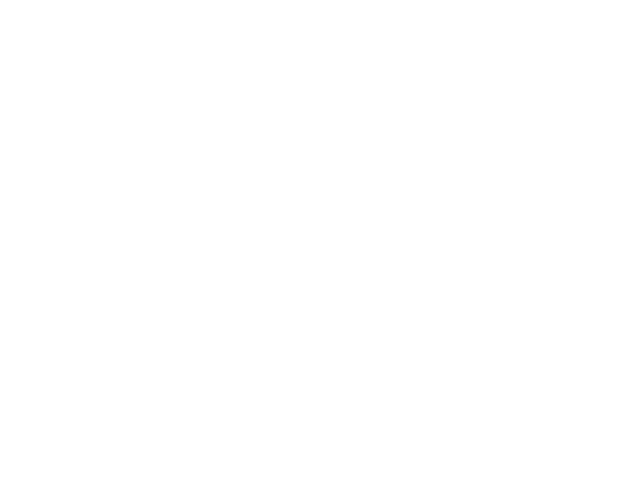

Gratings - apertured size: 30
Blobs - min/max size: (10, 50)
('stimuli presented @:', 20.0, 8.0)


<IPython.core.display.Javascript object>


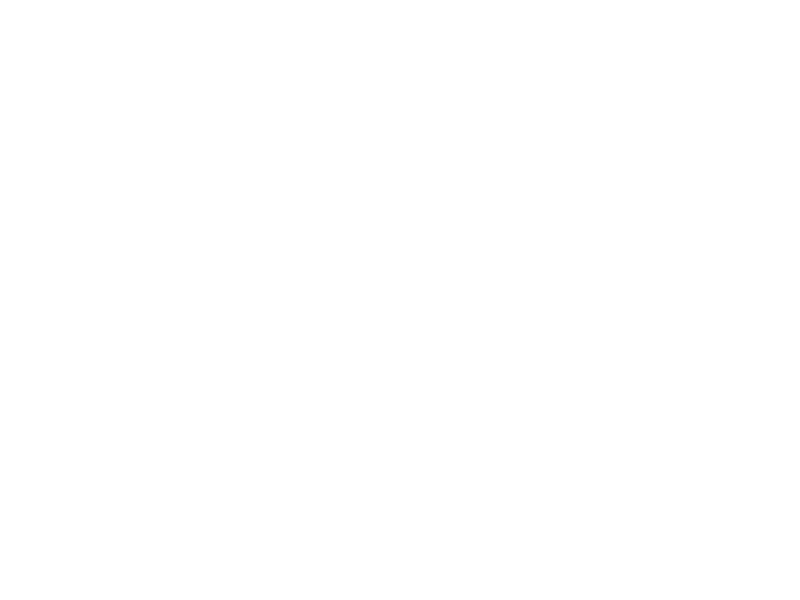

Lm JC084
... creating new session object
[JC084] 20190525 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... new session object to: /n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/summaries/sessiondata.pkl
('... got session object w/ experiments:', {})
('Found 4 experiments in current session:', ['rfs', 'gratings', 'blobs', 'retino'])
Calculating stats
[rfs] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'rfs')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (rfs - traces001 - corrected)
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... [JC084|20190525|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... loading data array
/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_be2b53_traces001_86ecb3_traces001_e0acc9_tra

<IPython.core.display.Javascript object>


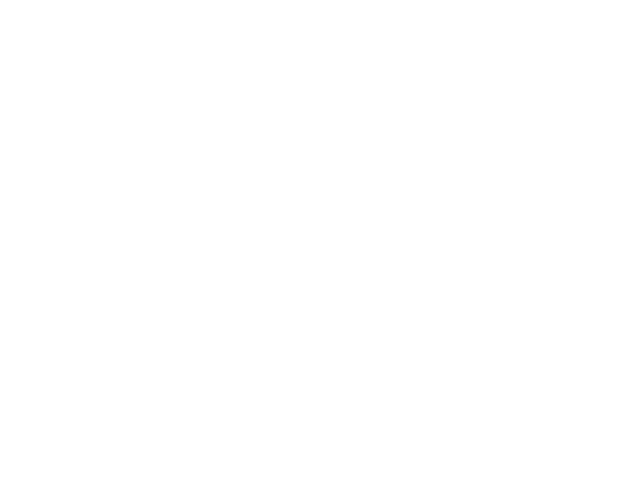

Gratings - apertured size: 30
Blobs - min/max size: (10, 50)
('stimuli presented @:', 20.0, 0.0)


<IPython.core.display.Javascript object>


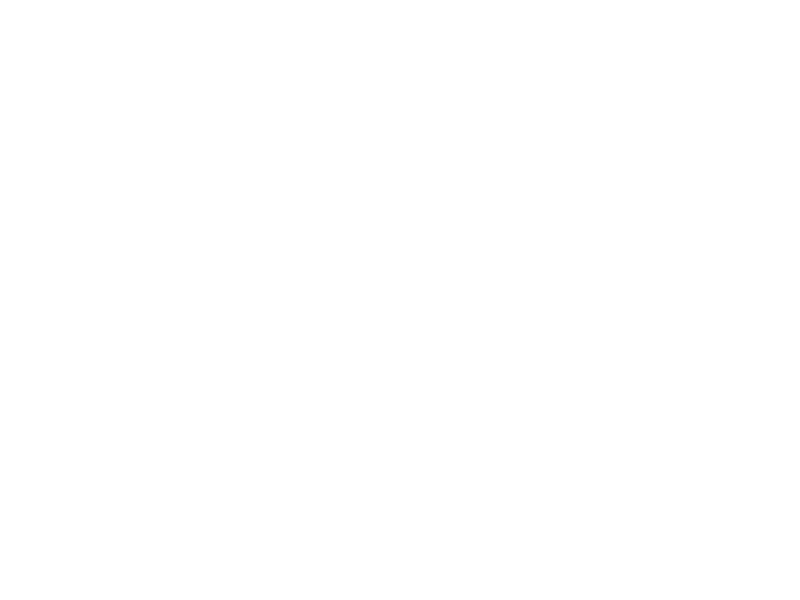

Lm JC091
... creating new session object
[JC091] 20190627 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... new session object to: /n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/summaries/sessiondata.pkl
('... got session object w/ experiments:', {})
('Found 4 experiments in current session:', ['rfs', 'gratings', 'blobs', 'retino'])
Calculating stats
[rfs] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'rfs')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (rfs - traces001 - corrected)
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... [JC091|20190627|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... loading data array
/n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_013791_traces001_1e744a_traces001_e41aae_tra

<IPython.core.display.Javascript object>


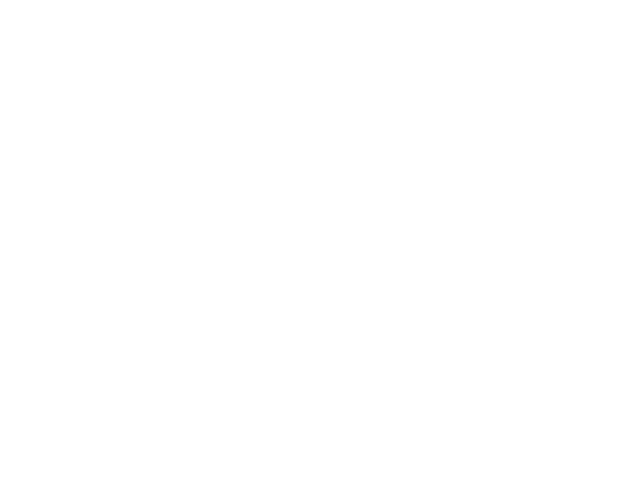

Gratings - apertured size: 30
Blobs - min/max size: (10, 50)
('stimuli presented @:', 10.0, -5.0)


<IPython.core.display.Javascript object>


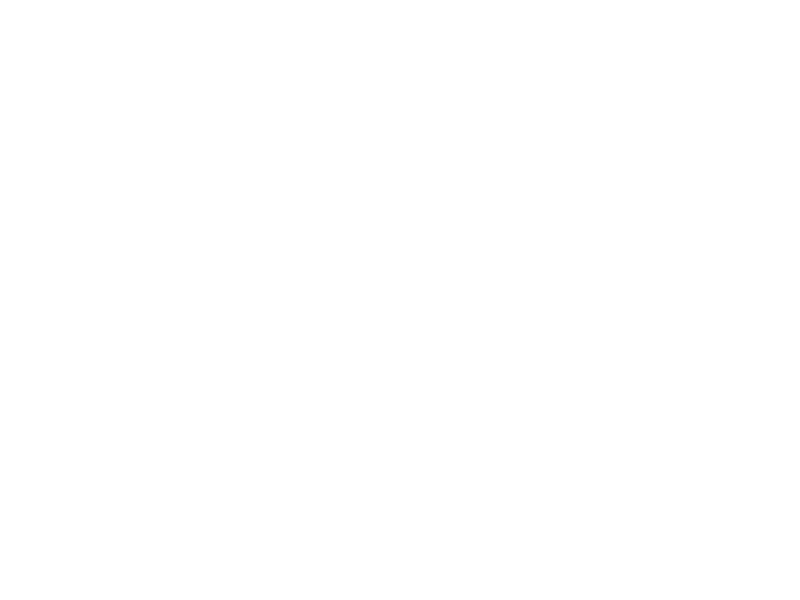

V1 JC076
... creating new session object
[JC076] 20190420 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... new session object to: /n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0x/summaries/sessiondata.pkl
('... got session object w/ experiments:', {})
('Found 3 experiments in current session:', ['blobs', 'retino', 'rfs'])
Calculating stats
[blobs] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'blobs')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (blobs - traces001 - corrected)
('... Getting experiment data:', ['blobs'])
... ... loading: blobs
... ... got rois
... [JC076|20190420|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... loading data array
/n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_5ffca7_traces001_09c921_traces001_512e

<IPython.core.display.Javascript object>


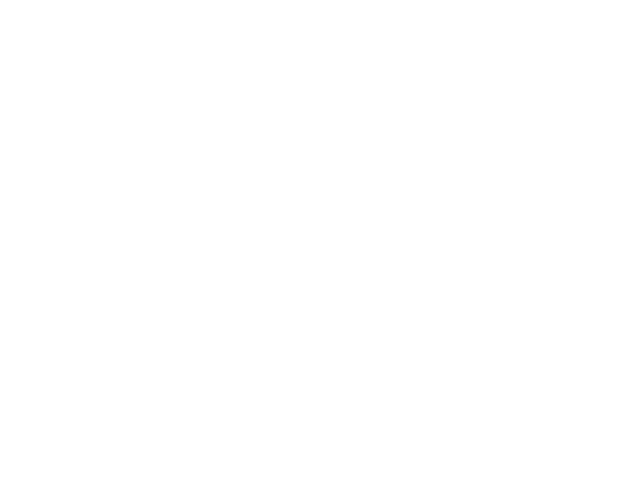

No localized gratings
Blobs - min/max size: (10, 50)
('stimuli presented @:', 30.0, 5.0)


<IPython.core.display.Javascript object>


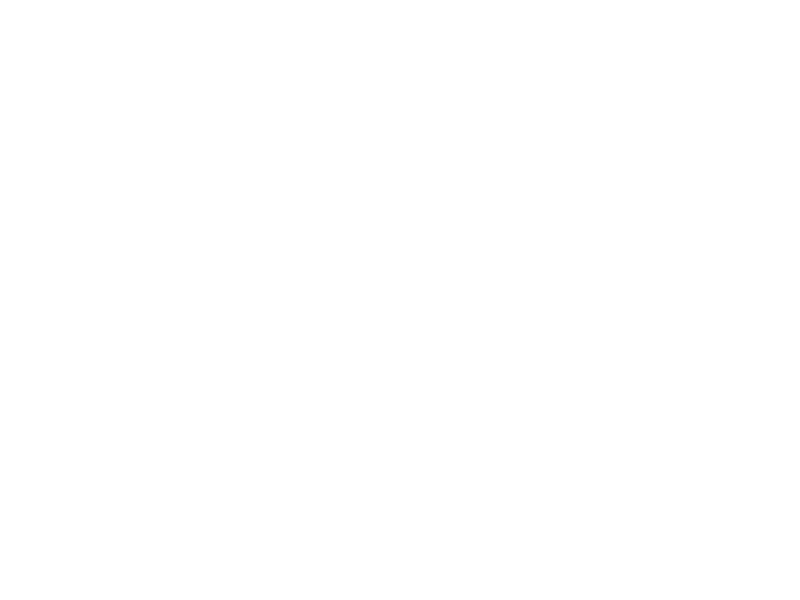

V1 JC076
... creating new session object
[JC076] 20190501 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... new session object to: /n/coxfs01/2p-data/JC076/20190501/FOV1_zoom2p0x/summaries/sessiondata.pkl
('... got session object w/ experiments:', {})
('Found 3 experiments in current session:', ['blobs', 'retino', 'rfs'])
Calculating stats
[blobs] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'blobs')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (blobs - traces001 - corrected)
('... Getting experiment data:', ['blobs'])
... ... loading: blobs
... ... got rois
... [JC076|20190501|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... loading data array
/n/coxfs01/2p-data/JC076/20190501/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_8bada5_traces001_f32281_traces001_8843

Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 368, in aggregate_experiment_runs
    parsed_frames_fpath = glob.glob(os.path.join(rundir, 'paradigm', 'parsed_frames_*.hdf5'))[0] #' in pfn][0]
IndexError: list index out of range
Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 368, in aggregate_experiment_runs
    parsed_frames_fpath = glob.glob(os.path.join(rundir, 'paradigm', 'parsed_frames_*.hdf5'))[0] #' in pfn][0]
IndexError: list index out of range
Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 368, in aggregate_experiment_runs
    parsed_frames_fpath = glob.glob(os.path.join(rundir, 'paradigm', 'parsed_frames_*.hdf5'))[0] #' in pfn][0

**** File 5 of 55 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190501/FOV1_zoom2p0x/gratings_run1
**** File 6 of 55 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190501/FOV1_zoom2p0x/gratings_run1
**** File 7 of 55 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190501/FOV1_zoom2p0x/gratings_run1
**** File 8 of 55 *****


Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 368, in aggregate_experiment_runs
    parsed_frames_fpath = glob.glob(os.path.join(rundir, 'paradigm', 'parsed_frames_*.hdf5'))[0] #' in pfn][0]
IndexError: list index out of range
Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 368, in aggregate_experiment_runs
    parsed_frames_fpath = glob.glob(os.path.join(rundir, 'paradigm', 'parsed_frames_*.hdf5'))[0] #' in pfn][0]
IndexError: list index out of range
Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 368, in aggregate_experiment_runs
    parsed_frames_fpath = glob.glob(os.path.join(rundir, 'paradigm', 'parsed_frames_*.hdf5'))[0] #' in pfn][0

*** Excluding: []
/n/coxfs01/2p-data/JC076/20190501/FOV1_zoom2p0x/gratings_run1
**** File 9 of 55 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190501/FOV1_zoom2p0x/gratings_run1
**** File 10 of 55 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190501/FOV1_zoom2p0x/gratings_run1
**** File 11 of 55 *****


Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 368, in aggregate_experiment_runs
    parsed_frames_fpath = glob.glob(os.path.join(rundir, 'paradigm', 'parsed_frames_*.hdf5'))[0] #' in pfn][0]
IndexError: list index out of range
Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 368, in aggregate_experiment_runs
    parsed_frames_fpath = glob.glob(os.path.join(rundir, 'paradigm', 'parsed_frames_*.hdf5'))[0] #' in pfn][0]
IndexError: list index out of range
Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 368, in aggregate_experiment_runs
    parsed_frames_fpath = glob.glob(os.path.join(rundir, 'paradigm', 'parsed_frames_*.hdf5'))[0] #' in pfn][0

*** Excluding: []
/n/coxfs01/2p-data/JC076/20190501/FOV1_zoom2p0x/gratings_run1
**** File 12 of 55 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190501/FOV1_zoom2p0x/gratings_run2
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 0 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -62.65748278021317
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -309.79877427100587
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -313.928579757463
STIM TYPE: gratings
**** File 13 of 55 *****
*** Excluding: []
/n/coxfs01/2p-data/J

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -72.67831392124245
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -1303.8887393472455
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -1263.820618586754
STIM TYPE: gratings
**** File 22 of 55 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190501/FOV1_zoom2p0x/gratings_run2
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 10 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -55.907534246575324
Showing initial drift correction (quantile: 0.1

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -30.190850607576863
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -637.9539122961581
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -598.2076725746269
STIM TYPE: gratings
**** File 32 of 55 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190501/FOV1_zoom2p0x/gratings_run3
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 9 (has 2911 frames)
... asking for 10 extra frames...
... Last frame to align: 2921 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -35.95537287140337
Showing initial drift correction (quantile: 0.10)

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -52.60337005832764
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -495.6397382445414
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -463.9326317630598
STIM TYPE: gratings
**** File 42 of 55 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190501/FOV1_zoom2p0x/gratings_run4
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 8 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -61.86620530565153
Showing initial drift correction (quantile: 0.10)


Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -57.22487113402053
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -191.06536782234667
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -205.67742828824612
STIM TYPE: gratings
**** File 52 of 55 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190501/FOV1_zoom2p0x/gratings_run5
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 7 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -52.82628313592778
Showing initial drift correction (quantile: 0.10

<IPython.core.display.Javascript object>


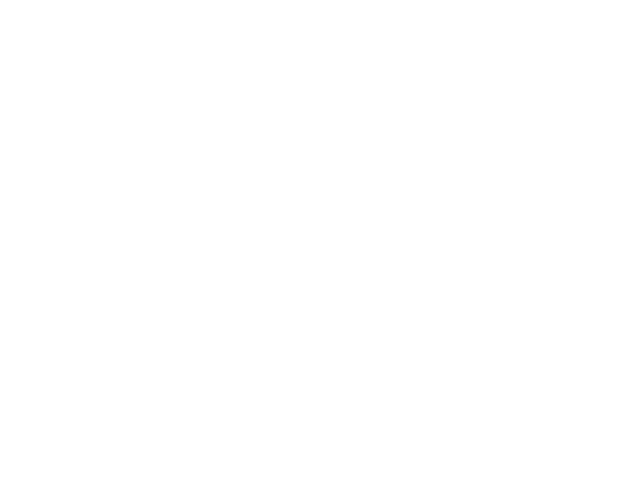

No localized gratings
Blobs - min/max size: (10, 50)
('stimuli presented @:', 30.0, 0.0)


<IPython.core.display.Javascript object>


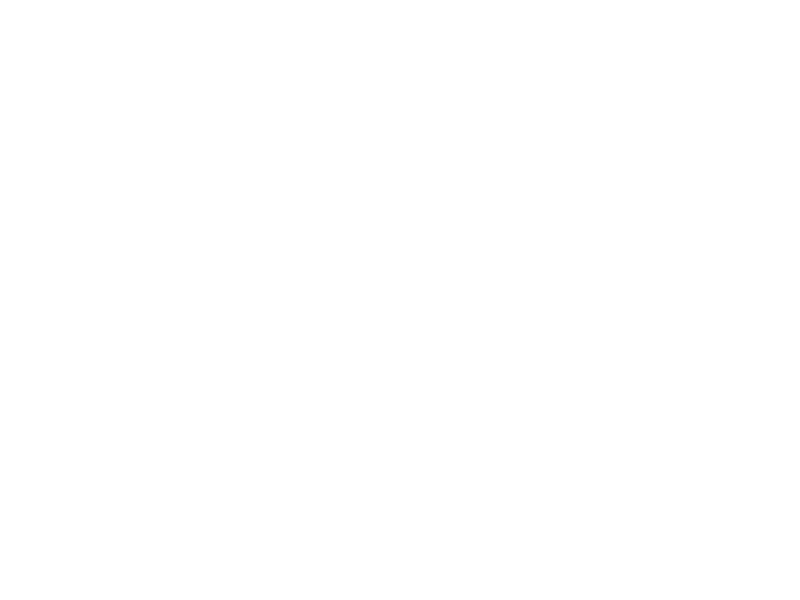

V1 JC083
... creating new session object
[JC083] 20190507 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC083 | 20190507 | FOV1_zoom2p0x)
... Getting screen info
... new session object to: /n/coxfs01/2p-data/JC083/20190507/FOV1_zoom2p0x/summaries/sessiondata.pkl
('... got session object w/ experiments:', {})
('Found 3 experiments in current session:', ['blobs', 'retino', 'rfs'])
Calculating stats
[blobs] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'blobs')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (blobs - traces001 - corrected)
('... Getting experiment data:', ['blobs'])
... ... loading: blobs
... ... got rois
... [JC083|20190507|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... loading data array
/n/coxfs01/2p-data/JC083/20190507/FOV1_zoom2p0x/combined_blobs_static/traces/traces

<IPython.core.display.Javascript object>


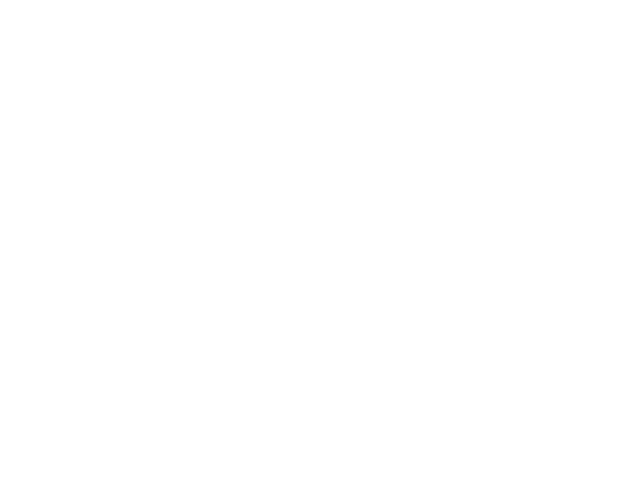

No localized gratings
Blobs - min/max size: (10, 50)
('stimuli presented @:', 20.0, 5.0)


<IPython.core.display.Javascript object>


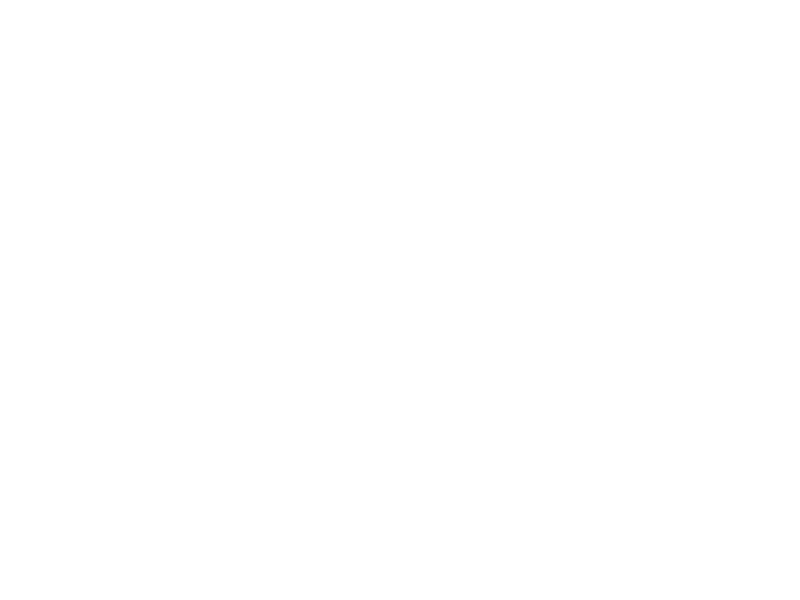

V1 JC083
... creating new session object
[JC083] 20190510 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC083 | 20190510 | FOV1_zoom2p0x)
... Getting screen info
... new session object to: /n/coxfs01/2p-data/JC083/20190510/FOV1_zoom2p0x/summaries/sessiondata.pkl
('... got session object w/ experiments:', {})
('Found 3 experiments in current session:', ['blobs', 'retino', 'rfs'])
Calculating stats
[blobs] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'blobs')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (blobs - traces001 - corrected)
('... Getting experiment data:', ['blobs'])
... ... loading: blobs
... ... got rois
... [JC083|20190510|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... loading data array
/n/coxfs01/2p-data/JC083/20190510/FOV1_zoom2p0x/combined_blobs_static/traces/traces

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -50.42219020172922
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -175.60298992727252
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -169.8425114329267
STIM TYPE: gratings
**** File 8 of 73 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190510/FOV1_zoom2p0x/gratings_run1
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2897
... File: 7 (has 2911 frames)
... asking for 12 extra frames...
... Last frame to align: 2923 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -36.25569290826297
Showing initial drift correction (quantile: 0.10)


Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -55.56793893129759
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -265.18731293794247
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -263.99943462171086
STIM TYPE: gratings
**** File 18 of 73 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190510/FOV1_zoom2p0x/gratings_run2
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 6 (has 2911 frames)
... asking for 12 extra frames...
... Last frame to align: 2923 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -47.297668038408574
Showing initial drift correction (quantile: 0.1

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -48.0865771812081
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -203.86215644711842
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -175.46542968750003
STIM TYPE: gratings
**** File 28 of 73 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190510/FOV1_zoom2p0x/gratings_run3
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 5 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -47.242480049109986
Showing initial drift correction (quantile: 0.10

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -53.903933434190776
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -534.4377569945314
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -559.0540540540546
STIM TYPE: gratings
**** File 38 of 73 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190510/FOV1_zoom2p0x/gratings_run4
N tsecs: 2911
There are 284 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 4 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -58.56870229007666
Showing initial drift correction (quantile: 0.10)

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -89.21006711409404
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -410.7673811401128
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -441.1482216282898
STIM TYPE: gratings
**** File 48 of 73 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190510/FOV1_zoom2p0x/gratings_run5
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 7 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -71.01484560570088
Showing initial drift correction (quantile: 0.10)


Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -62.31145431145467
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -421.5567329853575
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -425.87884457236805
STIM TYPE: gratings
**** File 58 of 73 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190510/FOV1_zoom2p0x/gratings_run6
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 6 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -81.57862595419817
Showing initial drift correction (quantile: 0.10)

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -69.68641975308628
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -703.6879203711878
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -755.6202097039459
STIM TYPE: gratings
**** File 68 of 73 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190510/FOV1_zoom2p0x/gratings_run7
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 5 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -65.74603174603158
Showing initial drift correction (quantile: 0.10)


<IPython.core.display.Javascript object>


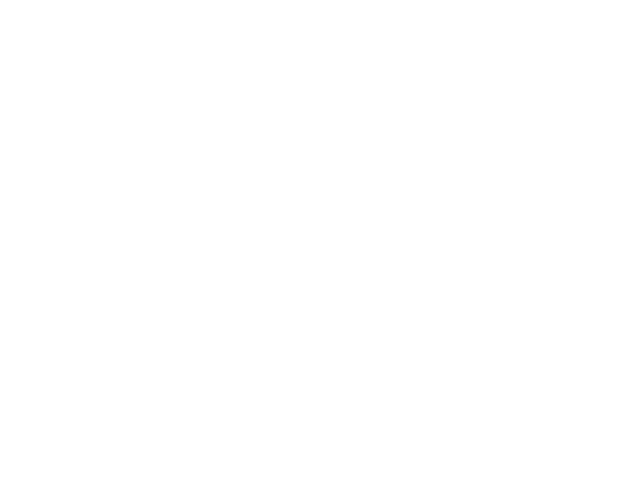

No localized gratings
Blobs - min/max size: (10, 50)
('stimuli presented @:', 20.0, 5.0)


<IPython.core.display.Javascript object>


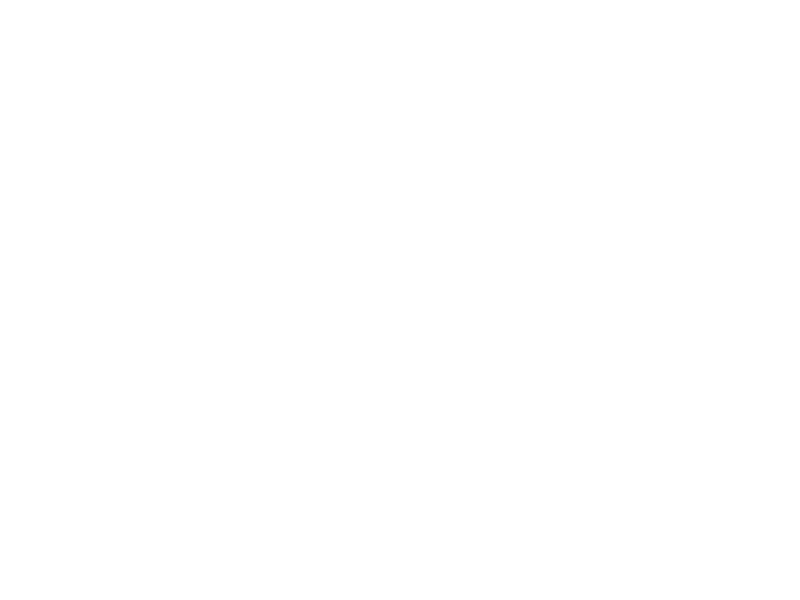

V1 JC083
... creating new session object
[JC083] 20190511 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC083 | 20190511 | FOV1_zoom2p0x)
... Getting screen info
... new session object to: /n/coxfs01/2p-data/JC083/20190511/FOV1_zoom2p0x/summaries/sessiondata.pkl
('... got session object w/ experiments:', {})
('Found 4 experiments in current session:', ['rfs', 'gratings', 'blobs', 'retino'])
Calculating stats
[rfs] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'rfs')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (rfs - traces001 - corrected)
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... [JC083|20190511|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... loading data array
/n/coxfs01/2p-data/JC083/20190511/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_06

Frame indices are NOT block indexed
... N frames to align: 2772
... N unique frames: 1958
... File: 8 (has 1952 frames)
... asking for 10 extra frames...
... Last frame to align: 1962 (N frames total, 1952)
... N tstamps: 1952
... padding trial tstamps array... (should be 2772)
N frames per trial: 66
N tstamps: 2772
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -45.869152542372944
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -231.66683546215143
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -245.52880859375023
STIM TYPE: gratings
**** File 10 of 60 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190511/FOV1_zoom2p0x/rfs_run1
N tsecs: 1952
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 2772
... N unique frames: 1958
... File: 9 (has 1952 frames)
... asking for 10 extra f

Frame indices are NOT block indexed
... N frames to align: 2772
... N unique frames: 1958
... File: 2 (has 1952 frames)
... asking for 9 extra frames...
... Last frame to align: 1961 (N frames total, 1952)
... N tstamps: 1952
... padding trial tstamps array... (should be 2772)
N frames per trial: 66
N tstamps: 2772
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -63.727086183310576
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -218.3621923071239
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -226.00628662109375
STIM TYPE: gratings
**** File 20 of 60 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190511/FOV1_zoom2p0x/rfs_run3
N tsecs: 1952
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 2772
... N unique frames: 1958
... File: 3 (has 1952 frames)
... asking for 10 extra fra

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -273.54296875
STIM TYPE: gratings
**** File 29 of 60 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190511/FOV1_zoom2p0x/rfs_run4
N tsecs: 1952
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 2772
... N unique frames: 1958
... File: 1 (has 1952 frames)
... asking for 10 extra frames...
... Last frame to align: 1962 (N frames total, 1952)
... N tstamps: 1952
... padding trial tstamps array... (should be 2772)
N frames per trial: 66
N tstamps: 2772
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -54.753191489361484
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -247.89644660537124
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -249.22142836626824
STIM TYPE: gratings
**** File 30 of 60 *****
*** Excludin

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -61.238276299112954
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -201.77897784788775
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -219.54365907866378
STIM TYPE: gratings
**** File 39 of 60 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190511/FOV1_zoom2p0x/rfs_run5
N tsecs: 1952
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 2772
... N unique frames: 1958
... File: 0 (has 1952 frames)
... asking for 10 extra frames...
... Last frame to align: 1962 (N frames total, 1952)
... N tstamps: 1952
... padding trial tstamps array... (should be 2772)
N frames per trial: 66
N tstamps: 2772
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -48.67312834224572
Showing initial drift correction (quantile: 0.10)
Mi

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -45.70128205128219
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -335.16868074945273
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -340.7656537224261
STIM TYPE: gratings
**** File 49 of 60 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190511/FOV1_zoom2p0x/rfs_run5
N tsecs: 1952
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 2772
... N unique frames: 1958
... File: 10 (has 1952 frames)
... asking for 10 extra frames...
... Last frame to align: 1962 (N frames total, 1952)
... N tstamps: 1952
... padding trial tstamps array... (should be 2772)
N frames per trial: 66
N tstamps: 2772
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -47.20638297872358
Showing initial drift correction (quantile: 0.10)
Min

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -52.43763518385015
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -208.78385139085816
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -214.72059631347656
STIM TYPE: gratings
**** File 59 of 60 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190511/FOV1_zoom2p0x/rfs_run6
N tsecs: 1952
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 2772
... N unique frames: 1958
... File: 9 (has 1952 frames)
... asking for 9 extra frames...
... Last frame to align: 1961 (N frames total, 1952)
... N tstamps: 1952
... padding trial tstamps array... (should be 2772)
N frames per trial: 66
N tstamps: 2772
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -78.38987688098518
Showing initial drift correction (quantile: 0.10)
Min 

In [ ]:
for (visual_area, animalid, session, fov), dset in sdata.groupby(['visual_area', 'animalid', 'session', 'fov']):
    if 'rfs' not in dset['experiment'].values and 'rfs10' not in dset['experiment'].values:
        continue
    if 'blobs' not in dset['experiment'].values:
        continue
    print visual_area, animalid
    
    S = get_session_object(animalid, session, fov, traceid=traceid, trace_type=trace_type,
                       create_new=True, rootdir=rootdir)
    # Get Receptive Field measures:
    rf_exp_name = 'rfs10' if 'rfs10' in S.experiment_list else 'rfs'


    # Get grouped roi stat metrics:
    gdfs, statsdir, stats_desc, nostats = rstats.get_session_stats(S, response_type=response_type, 
                                                          experiment_list=S.experiment_list,
                                                          responsive_test=responsive_test, 
                                                          responsive_thr=responsive_thr,
                                                          traceid=traceid, trace_type=trace_type,
                                                          create_new=True, rootdir=rootdir,
                                                          pretty_plots=False, update_self=True)
    roi_list = gdfs[rf_exp_name].rois
    data_identifier = '|'.join([S.animalid, S.session, S.fov, S.traceid, S.rois])
    data_identifier
    
    # Get stimulus info for RFs
    row_vals = gdfs[rf_exp_name].fitinfo['row_vals']
    col_vals = gdfs[rf_exp_name].fitinfo['col_vals']
    xres = np.unique(np.diff(row_vals))[0]
    yres = np.unique(np.diff(col_vals))[0]
    print("x-/y-res: %i, %i" % (xres, yres))

    # Identify stimulus location for current session
    xpos, ypos = S.get_stimulus_coordinates()

#     # Get stimulus size(s)
#     stimsizes = S.get_stimulus_sizes()
#     print("sizes:", stimsizes)

    # Get screen bounds [bottom left upper right]
    screen_bounds = [S.screen['linminH'], S.screen['linminW'], S.screen['linmaxH'], S.screen['linmaxW']]
    screen_aspect = S.screen['resolution'][0] / S.screen['resolution'][1]

    stiminfo = {'stimulus_sizes': S.get_stimulus_sizes(),
                'screen_bounds': screen_bounds,
                'screen_aspect': screen_aspect,
                'stimulus_xpos': xpos,
                'stimulus_ypos': ypos}

    # Get FOV info
    masks, zimg = S.load_masks(rois='rois001')
    rf_rois = gdfs[rf_exp_name].fits.index.tolist() 
    fovinfo = coor.get_roi_fov_info(masks, zimg, roi_list=rf_rois)
    print("... got FOV info.")
    
    # Convert RF params into shape
    rf_polys = rfs_to_polys(gdfs[rf_exp_name].fits)

    # Vectorize shapes
    miny, minx, maxy, maxx = screen_bounds #[-Y, -X, +Y, +X]
    
    # Create vertex coordinates for each grid cell...
    xx = np.arange(minx, maxx, dx)
    yy = np.arange(miny, maxy, dy)
    nx = len(xx)
    ny = len(yy)
    x, y = np.meshgrid(xx, yy)
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T

    path = Path(np.array(rf_polys[0].exterior.coords.xy).T)
    grid = path.contains_points(points).astype(int)

    for rp in rf_polys[1:]:
        poly_verts = np.array(rp.exterior.coords.xy).T
        path = Path(poly_verts)
        grid += path.contains_points(points).astype(int)
    grid = grid.reshape((ny,nx))

    # Normalize
    #grid = grid / float(len(rf_polys))
    
    # Plot
    fig, ax = pl.subplots()
    im = ax.imshow(grid, extent=(minx, maxx, miny, maxy), origin='lower', cmap='bone')
    ax_divider = make_axes_locatable(ax)
    # add an axes to the right of the main axes.
    cax = ax_divider.append_axes("right", size="5%", pad="2%")
    cb1 = pl.colorbar(im, cax=cax)
    ax.plot(xpos, ypos, 'r*')
    label_figure(fig, data_identifier)
    pl.savefig(os.path.join(outdir, 'heatmaps', '%s_%s-%s-%s_RF-heatmap.png' % (visual_area, animalid, session, fov)))
    pl.close()
    
    # Calculate and visualize overlap stats
    rf_avg_size = np.mean([abs(gdfs[rf_exp_name].fits['sigma_x'])*sigma_scale, \
                         abs(gdfs[rf_exp_name].fits['sigma_y'])*sigma_scale], axis=0)
    rf_dist_from_center = np.sqrt((gdfs[rf_exp_name].fits['x0'] - xpos)**2 \
                                + (gdfs[rf_exp_name].fits['y0'] - ypos)**2)

    overlap_df = get_overlap_stats(roi_list, rf_polys, rf_dist_from_center, stiminfo)
    fig = summarize_visual_field_coverage(gdfs, fovinfo, overlap_df, stiminfo,
                                    rf_polys, rf_avg_size, rf_dist_from_center)
    label_figure(fig, data_identifier)
    pl.savefig(os.path.join(outdir, 'summaries','%s_%s-%s-%s_VF-coverage-stats.png' % (visual_area, animalid, session, fov)))
    pl.close()

# Load data

In [88]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC076' #JC076'
session = '20190502' #'20190501'
fov = 'FOV1_zoom2p0x'

traceid = 'traces001'

create_new = False
trace_type = 'corrected'
responsive_test = 'nstds'
responsive_thr = 10.
convert_um = True


In [89]:
S = get_session_object(animalid, session, fov, traceid=traceid, trace_type=trace_type,
                       create_new=create_new, rootdir=rootdir)


... loading session object
('... got session object w/ experiments:', {})
('Found 2 experiments in current session:', ['blobs', 'rfs'])


In [90]:
# Get Receptive Field measures:
rf_exp_name = 'rfs10' if 'rfs10' in S.experiment_list else 'rfs'


response_type = 'dff'

# Get grouped roi stat metrics:
gdfs, statsdir, stats_desc, nostats = rstats.get_session_stats(S, response_type=response_type, 
                                                      experiment_list=S.experiment_list,
                                                      responsive_test=responsive_test, 
                                                      responsive_thr=responsive_thr,
                                                      traceid=traceid, trace_type=trace_type,
                                                      create_new=True, rootdir=rootdir,
                                                      pretty_plots=False, update_self=True)

print("statsdir=%s" % statsdir)


Calculating stats
[blobs] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'blobs')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (blobs - traces001 - corrected)
('... Getting experiment data:', ['blobs'])
... ... loading: blobs
... ... got rois
... [JC076|20190502|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... loading data array
/n/coxfs01/2p-data/JC076/20190502/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_bc0893_traces001_05b262_traces001_cdf7b0_traces001_2649ff_traces001_e62928_traces001_82b664/data_arrays/np_subtracted.npz
adding NP offset...
... adjusting for equal reps / condn...
... updating self
... ... loaded traces
... blobs: calculating stats
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
[rfs] 

In [91]:
data_identifier = '|'.join([S.animalid, S.session, S.fov, S.traceid, S.rois])
data_identifier

u'JC076|20190502|FOV1_zoom2p0x|traces001|rois001'

In [92]:
for k in gdfs.keys():
    print('%s: %i (of %i)' % (k, len(gdfs[k].rois), gdfs[k].nrois))

rfs: 21 (of 64)
blobs: 148 (of 226)


# Get stimulus info

In [93]:
# RF conversion info
sigma_scale = 2.35
min_sigma=5
max_sigma=50

row_vals = gdfs[rf_exp_name].fitinfo['row_vals']
col_vals = gdfs[rf_exp_name].fitinfo['col_vals']
xres = np.unique(np.diff(row_vals))[0]
yres = np.unique(np.diff(col_vals))[0]
print("x-/y-res: %i, %i" % (xres, yres))
    

x-/y-res: 5, 5


In [96]:
# Identify stimulus location for current session:
xpos, ypos = S.get_stimulus_coordinates()
    
# Get stimulus size(s):
stimsizes = S.get_stimulus_sizes()
print("sizes:", stimsizes)


# Get size range of stimuli shown:
if 'gratings' in stimsizes.keys():
    gratings_sz = min(stimsizes['gratings'])
    print("Gratings - apertured size: %i" % gratings_sz)

blobs_sz_min = min(stimsizes['blobs'])
blobs_sz_max = max(stimsizes['blobs'])
print("Blobs - min/max size: (%i, %i)" % (blobs_sz_min, blobs_sz_max))

stiminfo = {'stimulus_sizes': S.get_stimulus_sizes(),
            'screen_bounds': screen_bounds,
            'screen_aspect': screen_aspect,
            'stimulus_xpos': xpos,
            'stimulus_ypos': ypos}


[JC076|20190502] No experiment exists for: gratings
Stimuli presented at coords: (-5, 8)
('sizes:', {'blobs': array([10, 20, 30, 40, 50])})
Blobs - min/max size: (10, 50)


# Get FOV info

In [97]:
masks, zimg = S.load_masks(rois='rois001')
print(masks.shape)

rf_rois = gdfs[rf_exp_name].fits.index.tolist() 
fovinfo = coor.get_roi_fov_info(masks, zimg, roi_list=rf_rois)
print("Got FOV info:")
fovinfo.keys()

(512, 512, 226)
... getting fov info
Created 226 contours for rois.
Got FOV info:


['roi_contours', 'positions', 'ap_lim', 'zimg', 'ml_lim']

# Calculate screen coverage

In [98]:
from matplotlib.patches import Ellipse, Rectangle, Polygon
from shapely.geometry.point import Point
from shapely.geometry import box
from shapely import affinity
from shapely.ops import cascaded_union

def create_ellipse(center, lengths, angle=0):
    """
    create a shapely ellipse. adapted from
    https://gis.stackexchange.com/a/243462
    """
    circ = Point(center).buffer(1)
    ell = affinity.scale(circ, int(lengths[0]), int(lengths[1]))
    ellr = affinity.rotate(ell, angle)
    return ellr


In [99]:
def rfs_to_polys(rffits, sigma_scale=2.35):
    '''
    rffits (pd dataframe)
        index : roi indices (same as gdf.rois)
        columns : r2, sigma_x, sigma_y, theta, x0, y0 (already converted) 
        
    '''
    rf_polys=[]
    for roi in rffits.index.tolist():
        _, sx, sy, th, x0, y0 = rffits.loc[roi]
        s_ell = create_ellipse((x0, y0), (abs(sx)*sigma_scale, abs(sy)*sigma_scale), np.rad2deg(th))
        rf_polys.append(s_ell)
    return rf_polys



In [100]:

# Get screen bounds: [bottom left upper right]
screen_bounds = [S.screen['linminH'], S.screen['linminW'], S.screen['linmaxH'], S.screen['linmaxW']]
screen_aspect = S.screen['resolution'][0] / S.screen['resolution'][1]


In [101]:
rf_polys = rfs_to_polys(gdfs[rf_exp_name].fits)

rf_avg_size = np.mean([abs(gdfs[rf_exp_name].fits['sigma_x'])*sigma_scale, \
                     abs(gdfs[rf_exp_name].fits['sigma_y'])*sigma_scale], axis=0)
rf_dist_from_center = np.sqrt((gdfs[rf_exp_name].fits['x0'] - xpos)**2 \
                            + (gdfs[rf_exp_name].fits['y0'] - ypos)**2)


In [102]:
# # PLOT
# fig = pl.figure(figsize=(6,4))
# fig.patch.set_alpha(1)
# padding=2

# # Screen visualization ----------------------------------------------------
# ax0 = pl.subplot2grid((1, 2), (0, 0), colspan=2, rowspan=1)
# ax0.set_xlim([screen_bounds[1]*padding, screen_bounds[3]*padding])
# ax0.set_ylim([screen_bounds[0]*padding, screen_bounds[2]*padding])
# ax0.set_aspect(screen_aspect)
# ax0.tick_params(axis='both', which='both', length=0, labelsize=6)

# # Draw receptive fields, calculate overlap(s):
# rf_patches = [Polygon(np.array(rf_shape.exterior.coords.xy).T, 
#                       edgecolor='k', alpha=0.5, facecolor='none', lw=0.2)\
#                      for rf_shape in rf_polys]
# for rp in rf_patches:
#     ax0.add_patch(rp)

# merged = cascaded_union(rf_polys)
# #patch2b = PolygonPatch(merged, fc=BLUE, ec=BLUE, alpha=0.2, zorder=2)
# v_merged = np.array(merged.exterior.coords.xy)
# p_merged = Polygon( np.array(merged.exterior.coords.xy).T, edgecolor='none', 
#                    alpha=0.1, facecolor='blue', lw=0)
# ax0.add_patch(p_merged)
 

# Get extent of all RFs

In [103]:
screen_bounds

[-33.6615, -58.7792, 33.6615, 58.7792]

In [104]:
# y0, x0, y1, x1 = screen_bounds

#### Vectorize shapes and calculate overlaps as heatmap

In [105]:
from matplotlib.path import Path
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [106]:
max_shape = cascaded_union(rf_polys)
#minx, miny, maxx, maxy = max_shape.bounds
miny, minx, maxy, maxx = screen_bounds #[-Y, -X, +Y, +X]
print("X-min/max:", minx, maxx)
print("Y-min/max:", miny, maxy)

dx = dy = 1.0  # grid resolution; this can be adjusted

# Create vertex coordinates for each grid cell...
xx = np.arange(minx, maxx, dx)
yy = np.arange(miny, maxy, dy)
nx = len(xx)
ny = len(yy)

x, y = np.meshgrid(xx, yy)
x, y = x.flatten(), y.flatten()

points = np.vstack((x,y)).T

('X-min/max:', -58.7792, 58.7792)
('Y-min/max:', -33.6615, 33.6615)


In [107]:
path = Path(np.array(rf_polys[0].exterior.coords.xy).T)
grid = path.contains_points(points).astype(int)

for rp in rf_polys[1:]:
    poly_verts = np.array(rp.exterior.coords.xy).T
    path = Path(poly_verts)
    grid += path.contains_points(points).astype(int)
grid = grid.reshape((ny,nx))

# Normalize
grid = grid / float(len(rf_polys))

<IPython.core.display.Javascript object>


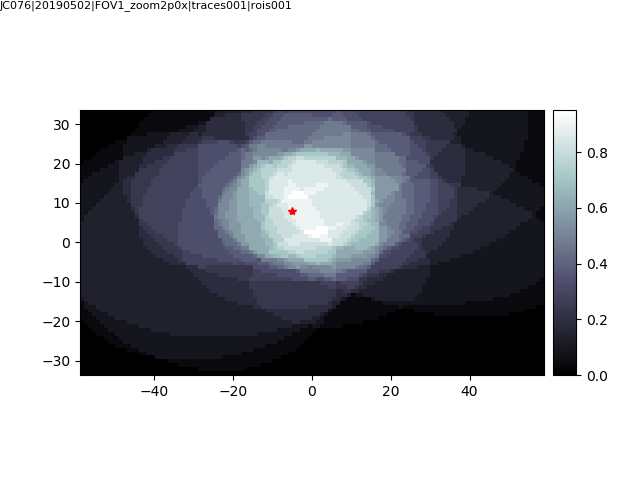

In [108]:
fig, ax = pl.subplots()
im = ax.imshow(grid, extent=(minx, maxx, miny, maxy), origin='lower', cmap='bone')
#fig.colorbar(im, ax=ax)

ax_divider = make_axes_locatable(ax)
# add an axes to the right of the main axes.
cax = ax_divider.append_axes("right", size="5%", pad="2%")
cb1 = pl.colorbar(im, cax=cax)

# extent : scalars (left, right, bottom, top), 
ax.plot(xpos, ypos, 'r*')
#ax.set_xticks(xx)
#ax.set_yticks(yy)

label_figure(fig, data_identifier)

# Visualize stimulus size/position range

In [109]:
roi_list = gdfs[rf_exp_name].rois

In [110]:
# Set colors
gratings_color = 'orange'
blobs_color = 'blue'
colordict = {'gratings': gratings_color,
            'blobs-min': blobs_color,
            'blobs-max': blobs_color}

#### Calculate overlaps bw RFs and stim sizes

In [111]:
## create BLOBS patch(es) - min/max

def stimsize_poly(sz, xpos=0, ypos=0):
    
    ry_min = ypos - sz/2.
    rx_min = xpos - sz/2.
    ry_max = ypos + sz/2.
    rx_max = xpos + sz/2.
    s_blobs = box(rx_min, ry_min, rx_max, ry_max)
    
    return s_blobs

In [121]:
def get_overlap_stats(roi_list, rf_polys, rf_dist_from_center, stiminfo):
    xpos = stiminfo['stimulus_xpos']
    ypos = stiminfo['stimulus_ypos']

    # Get size range of stimuli shown
    if 'gratings' in stiminfo['stimulus_sizes'].keys():
        gratings_sz = min(stiminfo['stimulus_sizes']['gratings'])
        print("Gratings - apertured size: %i" % gratings_sz)
    else:
        gratings_sz = None
        print("No localized gratings")
    blobs_sz_min = min(stiminfo['stimulus_sizes']['blobs'])
    blobs_sz_max = max(stiminfo['stimulus_sizes']['blobs'])
    print("Blobs - min/max size: (%i, %i)" % (blobs_sz_min, blobs_sz_max))

    # Create shapes for each stim size (bounding box)
    print("stimuli presented @:", xpos, ypos)
    stim_polys = [stimsize_poly(blob_sz, xpos=xpos, ypos=ypos)\
                  for blob_sz in stiminfo['stimulus_sizes']['blobs']]
    stim_labels = ['%i-deg' % blob_sz for blob_sz in stiminfo['stimulus_sizes']['blobs']]

    ## Caculate overlaps and put into dataframe
    overlaps=[]
    for s_label, s_poly in zip(stim_labels, stim_polys):
        tdf = pd.DataFrame({'overlap': [(s_ell.intersection(s_poly)).area / s_ell.area \
                                   for s_ell in rf_polys],
                            'distance': rf_dist_from_center,
                            'stimulus': [s_label for _ in range(len(rf_polys))],
                            'roi': roi_list})
        overlaps.append(tdf)

    if gratings_sz is not None:
        s_gratings = create_ellipse((xpos, ypos), (gratings_sz/2., gratings_sz/2.), 0)
        tdf = pd.DataFrame({'overlap': [(s_ell.intersection(s_gratings)).area / s_ell.area \
                                       for s_ell in rf_polys],
                            'distance': rf_dist_from_center,
                            'stimulus': ['gratings' for _ in range(len(rf_polys))],
                            'roi': roi_list})
        overlaps.append(tdf)

    overlap_df = pd.concat(overlaps)
    #overlap_df['color'] = [colordict[e] if e=='gratings' else 'cornflowerblue' for e in overlap_df['stimulus']]
    
    return overlap_df

In [122]:
overlap_df = get_overlap_stats(roi_list, rf_polys, rf_dist_from_center, stiminfo)

No localized gratings
Blobs - min/max size: (10, 50)
('stimuli presented @:', -5.0, 8.0)


In [114]:
overlap_df.head()

,distance,overlap,roi,stimulus
0,20.484103,0.000062,0,10-deg
7,26.977478,0.028154,7,10-deg
11,21.402507,0.030364,11,10-deg
84,20.822436,0.028801,169,10-deg
107,7.852289,0.081540,135,10-deg


In [115]:
overlap_df.head()

,distance,overlap,roi,stimulus
0,20.484103,0.000062,0,10-deg
7,26.977478,0.028154,7,10-deg
11,21.402507,0.030364,11,10-deg
84,20.822436,0.028801,169,10-deg
107,7.852289,0.081540,135,10-deg


##### PLOT 

In [116]:
colors = ['k' for _ in range(len(rf_rois))]
units = 'um'


In [117]:

def draw_rf_polys(rf_polys, ax=None):
    if ax is None:
        fig, ax = pl.subplots()
    rf_patches = [Polygon(np.array(rf_shape.exterior.coords.xy).T, 
                          edgecolor='k', alpha=0.5, facecolor='none', lw=0.2)\
                         for rf_shape in rf_polys]
    for rp in rf_patches:
        ax.add_patch(rp)
    return ax


def plot_overlap_distributions(overlap_df, ax=None):
    if ax is None:
        fig, ax = pl.subplots()

    ax = sns.boxplot(x="stimulus", y="overlap", data=overlap_df, ax=ax, color='k',
                     saturation=1.0, notch=True, boxprops=dict(alpha=.5))
    ax.set_xlabel('')
    ax.set_ylabel('Overlap area\n(% of RF)', fontsize=8)
    ax.tick_params(axis='both', which='both', length=0, labelsize=8)
    #ax.tick_params(axis='y', which='both', length=0, labelsize=8)
    sns.despine(trim=True, offset=4, ax=ax, bottom=True)
    return ax

def hist_rf_size(rf_avg_size, ax=None):
    if ax is None:
        fig, ax = pl.subplots()
    sns.distplot(rf_avg_size, ax=ax, color='k')
    ax.set_xlim([0, max(rf_avg_size)+10])
    ax.set_xlabel('Average RF size\n(deg)', fontsize=8)
    ax.set_ylabel('kde', fontsize=8)
    ax.tick_params(axis='both', which='both', length=3, labelsize=8)
    #ax2a.yaxis.set_major_locator(MaxNLocator(2))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    sns.despine(trim=True, offset=4, ax=ax)
    return ax

def hist_rf_dist(rf_dist_from_center, ax=None):
    if ax is None:
        fig, ax = pl.subplots()
    sns.distplot(rf_dist_from_center, ax=ax, color='k')
    ax.set_xlabel('RF distance from\nstimulus center', fontsize=8)
    ax.set_ylabel('kde', fontsize=8)
    ax.tick_params(axis='both', which='both', length=3, labelsize=8)
    #ymax = max([ax.get_ylim()[-1], ax.get_ylim()[-1]])
    #ax2b.set_ylim([0, ymax])
    #ax2b.yaxis.set_major_locator(MaxNLocator(2))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    sns.despine(trim=True, offset=4, ax=ax)
    return ax


def scatter_fovpos_rfpos(fovinfo, rffits, ax=None, axis='azimuth', 
                         xlim=58.78, ylim=33.66, units='um'):
    if ax is None:
        fig, ax = pl.subplots()
        
    if axis=='azimuth':
        ctx_pos = fovinfo['positions']['ml_pos']
        rf_pos = rffits['x0']
        axisname = 'Azimuth'
        miny = xlim*-1
        maxy = xlim
    else:
        ctx_pos = fovinfo['positions']['ap_pos']
        rf_pos = rffits['y0']
        axisname = 'Elevation'
        miny = ylim*-1
        maxy = ylim
        
    colors = ['k' for _ in range(len(ctx_pos))]
    ax.scatter(ctx_pos, rf_pos, c=colors, alpha=0.3) # FOV y-axis is left-right on brain
    ax.set_ylabel('%s\n(rel. deg.)' % axisname, fontsize=8)
    ax.set_xlabel('FOV position\n(%s)' % units, fontsize=8)
    ax.set_xticks(np.linspace(0, 1200, 5))
    ax.set_yticks(np.linspace(np.floor(miny), np.ceil(maxy), 5)) #[x0, x1])
    ax.yaxis.set_major_locator(MaxNLocator(5))

    return ax


In [127]:
def summarize_visual_field_coverage(gdfs, fovinfo, overlap_df, stiminfo,
                                    rf_polys, rf_avg_size, rf_dist_from_center):

    # PLOT
    fig = pl.figure(figsize=(8,6))
    fig.patch.set_alpha(1)

    # Screen visualization ----------------------------------------------------
    ax0 = pl.subplot2grid((3, 4), (0, 0), colspan=2, rowspan=1)
    screen_bounds = stiminfo['screen_bounds']
    ax0.set_xlim([screen_bounds[1], screen_bounds[3]])
    ax0.set_ylim([screen_bounds[0], screen_bounds[2]])
    ax0.set_aspect(stiminfo['screen_aspect'])
    ax0.tick_params(axis='both', which='both', length=0, labelsize=6)

    # Draw receptive fields, calculate overlap(s):
    ax0 = draw_rf_polys(rf_polys, ax=ax0)

    # Draw stimulus size patches:
    stim_polys = [stimsize_poly(blob_sz, xpos=xpos, ypos=ypos)\
                  for blob_sz in stiminfo['stimulus_sizes']['blobs']]
    stim_labels = ['%i-deg' % sz for sz in stiminfo['stimulus_sizes']['blobs']]
    stim_patches = [Polygon(np.array(stim_shape.exterior.coords.xy).T, 
                            edgecolor='orange', alpha=0.5, 
                            lw=2, facecolor='none', label=stim_label)\
                            for stim_label, stim_shape in zip(stim_labels, stim_polys)]
    ax0.add_patch(stim_patches[0])
    ax0.add_patch(stim_patches[-1])

    # ---- Proportion of RF overlapping with stimulus bounds ----
    ax = pl.subplot2grid((3, 4), (0, 2), colspan=2, rowspan=1)
    ax = plot_overlap_distributions(overlap_df, ax=ax)

    # ---- Average RF size -----------------------
    ax2a = pl.subplot2grid((3, 4), (1, 2), colspan=1, rowspan=1)
    ax2a = hist_rf_size(rf_avg_size, ax=ax2a)

    # ---- Distance from stimulus center -----------------------
    ax2b = pl.subplot2grid((3, 4), (1, 3), colspan=1, rowspan=1)
    ax2b = hist_rf_dist(rf_dist_from_center, ax=ax2b)

    # ---- Spatially sorted ROIs vs. RF position -----------------------
    ax3a = pl.subplot2grid((3, 4), (1, 0), colspan=1, rowspan=1)
    ax3a = scatter_fovpos_rfpos(fovinfo, gdfs[rf_exp_name].fits, ax=ax3a, axis='azimuth')
    ax3b = pl.subplot2grid((3, 4), (1, 1), colspan=1, rowspan=1)
    ax3b = scatter_fovpos_rfpos(fovinfo, gdfs[rf_exp_name].fits, ax=ax3b, axis='elevation')

    # Adjust subplots
    pl.subplots_adjust(left=0.1, top=0.9, right=0.99, wspace=0.6, hspace=0.5)
    bbox_s = ax2b.get_position()
    bbox_s2 = [bbox_s.x0 - 0.01, bbox_s.y0,  bbox_s.width, bbox_s.height] 
    ax2b.set_position(bbox_s2) # set a new position

    # Move upper-left plot over to reduce white space
    bbox = ax0.get_position()
    bbox2 = [bbox.x0 - 0.04, bbox.y0+0.0,  bbox.width-0.04, bbox.height+0.05] 
    ax0.set_position(bbox2) # set a new position

    return fig




In [124]:
stiminfo

{'screen_aspect': 1,
 'screen_bounds': [-33.6615, -58.7792, 33.6615, 58.7792],
 'stimulus_sizes': {'blobs': array([10, 20, 30, 40, 50])},
 'stimulus_xpos': -5.0,
 'stimulus_ypos': 8.0}

<IPython.core.display.Javascript object>


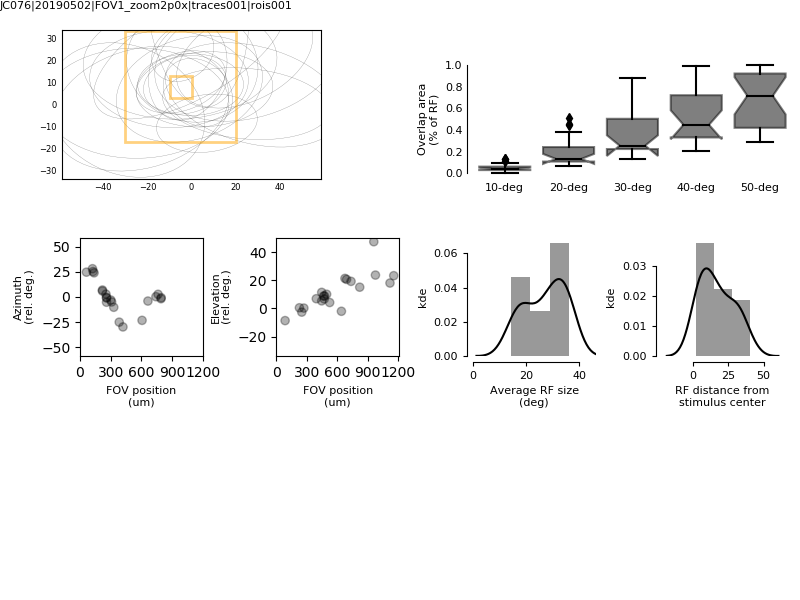

In [126]:
fig = summarize_visual_field_coverage(gdfs, fovinfo, overlap_df, stiminfo,
                                    rf_polys,
                                    rf_avg_size, rf_dist_from_center)
label_figure(fig, data_identifier)

#### Sort cells by overlap (or distance from center)

In [147]:
sortby_overlap = overlap_df.groupby(['stimulus']).get_group('gratings').sort_values(by='overlap')['roi']

In [148]:
sortby_dist = overlap_df.groupby(['stimulus']).get_group('gratings').sort_values(by='distance')['roi']

In [153]:
overlap_df[overlap_df['stimulus']=='gratings']['overlap'].max()

48.04947994710922